<a id="top"></a>

# Cleaning Residual 1/f Noise in NIRSpec BOTS Products with NSClean 
<hr style="border:1px solid black">

## Notebook Goal

The goal of this notebook is to generate cleaned BOTS (*_rateint.fits*) files by removing residual 1/f noise. These cleaned files will be used as input for the 3 (`TSO3Pipeline`) pipeline.


## Table of Contents

* 1. [Introduction](#introduction)
* 2. [Import Library](#imports)
* 3. [Download the Data](#data)
* 4. [Running `Spec2Pipeline` without NSClean (Original Data)](#nsclean_skipped)
    * 4.1 [Modifying the EXTRACT1D Reference File](#extract1d_mod)
* 5. [Clean up 1/f Noise with NSClean (Default Pipeline Mask)](#nsclean_default)
    * 5.1 [Verify the Mask (Default Pipeline Mask)](#verify_default_mask)
    * 5.2 [Comparing Original vs. Cleaned Data (Default Pipeline Mask)](#nsclean_default_compare)
* 6. [Clean up 1/f Noise with NSClean (Alternate Mask)](#nsclean_alternate)
    * 6.1 [Verify the Mask (Alternate Mask)](#verify_alternate_mask)
    * 6.2 [Comparing Original vs. Cleaned Data (Alternate Mask)](#nsclean_alternate_compare)
* 7. [Clean up 1/f Noise with NSClean (Hand-Modified Mask)](#nsclean_modified)
    * 7.1 [Verify the Mask (Hand-Modified Mask)](#verify_modified_mask)
    * 7.2 [Comparing Original vs. Cleaned Data (Hand-Modified Mask)](#nsclean_modified_compare)
* 8. [Conclusion](#conclusion)
* [About the Notebook](#about)


## 1. Introduction <a name="introduction"></a>
<hr style="border:1px solid black">

The JWST NIRSpec instrument has a number of features and characteristics that observers should be aware of when planning observations and interpreting data. One notable feature seen in NIRSpec pipeline products is negative and/or surplus flux in the extracted 1-D spectrum, typically with an irregular wavelength-dependent undulation. The cause of this artifact is correlated noise, known as [1/f noise](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrument-features-and-caveats#NIRSpecInstrumentFeaturesandCaveats-1/fnoise), from low-level detector thermal instabilities, seen as vertical banding in 2-D count rate images, particularly in exposures of the NRS2 detector. While the IRS2 readout mode reduces this effect, it is not completely eliminated.

To address this issue, the JWST Science Calibration Pipeline has integrated an external package developed by Bernard Rauscher, known as [NSClean](https://webb.nasa.gov/content/forScientists/publications.html#NSClean), within the `Spec2Pipeline` under [NSCleanStep](https://jwst-pipeline.readthedocs.io/en/latest/jwst/nsclean/main.html). This algorithm uses dark areas of the detector to fit a background model to the data in Fourier space. It requires an input mask to identify all dark areas of the detector. The more thorough and complete this mask is, the better the background fit.

In this notebook, we will use the NSClean algorithm integrated into the pipeline, utilizing a mask generated on-the-fly with default parameters to remove 1/f noise. In some cases, this mask may not be complete enough/too restrictive for the best possible noise removal. To address this, we demonstrate how one can manually modify the default mask, as well as how to create an alternative mask by adjusting the [NSCleanStep parameters](https://jwst-pipeline.readthedocs.io/en/latest/jwst/nsclean/arguments.html). If needed, see the [NSClean documentation](https://iopscience.iop.org/article/10.1088/1538-3873/ad1b36/pdf) for some suggestions on manually creating a custom mask.

This notebook utilizes transit data of WASP-39b observed in the BOTS G395H grism as part of the [JWST Early Release Science program ERS-1366](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366) observation 3, as an example.

## 2. Import Library <a name="imports"></a>
<hr style="border:1px solid black">


In [1]:
# ---------- Set CRDS environment variables ----------
import os
import jwst
os.environ['CRDS_CONTEXT'] = 'jwst_1215.pmap'
os.environ['CRDS_PATH'] = os.environ['HOME']+'/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
print(f'CRDS cache location: {os.environ["CRDS_PATH"]}')

print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
# print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

CRDS cache location: /home/runner/crds_cache
JWST Calibration Pipeline Version=1.14.0


In [2]:
# ------ General Imports ------
import numpy as np
import time as tt
import logging
import warnings
import json

# ------ JWST Calibration Pipeline Imports ------
from crds.client import api
from stpipe import crds_client
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

# ------ Plotting/Stats Imports ------
from matplotlib import pyplot as plt
from astropy.io import fits

from utils import get_jwst_file, plot_dark_data, plot_cleaned_data, plot_spectra

# Hide all log and warning messages.
logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

## 3. Download the Data <a name="data"></a>
<hr style="border:1px solid black">

The input data for this notebook features a transit of WASP-39b observed through the NIRSpec BOTS mode with the G395H grism. The dataset is part of the [JWST Early Release Science program ERS-1366](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366), specifically observation 3. It consists of 456 integrations with 70 groups each, using the SUB2048 subarray (array size of 2048 by 32 pixels per integration, per group). The entire observation spans 10.56 hours and is divided into three segments. This notebook focuses on the second segment (seg002) as an example. However, it's important to note that before proceeding to the `TSO3Pipeline`, all segments must first be processed through the `Spec2Pipeline`.

For a comprehensive overview of current and planned JWST Time-Series Observation (TSO) programs, particularly those involving transiting exoplanets with the NIRSpec BOTS mode, refer to [TrExoLiSTS](https://www.stsci.edu/~nnikolov/TrExoLiSTS/JWST/trexolists.html).

In [3]:
# Define a downloads directory.
mast_products_dir = "./mast_products/"
# Check if the directory exists.
if not os.path.exists(mast_products_dir):
    # Create the directory if it doesn't exist.
    os.makedirs(mast_products_dir)

In [4]:
# This notebook focuses on the second segment.
obs_ids = ["jw01366003001_04101_00001-seg002"]
detectors = [1, 2]  # Both Detectors NRS1 and NRS2.


# Specify the countrate products.
rateints_names = []

for obs_id in obs_ids:
    for detector in detectors:
        rateints_names.append(f"{obs_id}_nrs{detector}_rateints.fits")

# Download all the FITS files.
for name in rateints_names:
    print(f"Downloading {name}")
    get_jwst_file(
        name,
        mast_api_token=None,
        save_directory=mast_products_dir,
    )

## 4. Running `Spec2Pipeline` without NSClean (Original Data) <a name="nsclean_skipped"></a>
<hr style="border:1px solid black">

The cell below executes the `Spec2Pipeline`, explicitly skipping the NSClean step during processing. The level 2 products generated will serve as a reference point to illustrate how the countrate images and final extracted spectra appear without the removal of 1/f noise.

In [5]:
# Set up directory for running the pipeline without NSClean.
stage2_nsclean_skipped_dir = "./stage2_nsclean_skipped/"
if not os.path.exists(stage2_nsclean_skipped_dir):
    os.makedirs(stage2_nsclean_skipped_dir)  # Create the directory if it doesn't exist.

### 4.1 Modifying the EXTRACT1D Reference File <a name="extract1d_mod"></a>
<hr style="border:1px solid black">

We adjust the default parameter reference file for the `extract_1d` step, specifically modifying the extraction width aperture. This modification is necessary because the pipeline currently does not resample the 2D spectra to rectify the spectra (remove the curvature). Consequently, we rely on a broad extraction aperture, especially for NRS2.

In [6]:
# EXTRACT1D reference file for BOTS data NRS1.
refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0006.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0006.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    params["apertures"][0][
        "extract_width"
    ] = 27  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][0]["xstart"] = 100

    params["apertures"][0].pop("nod2_offset")  # Remove.
    params["apertures"][0].pop("nod3_offset")  # Remove.
    params["apertures"][0].pop("nod5_offset")  # Remove.

    params["apertures"][1][
        "extract_width"
    ] = 27  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][1]["xstart"] = 100
    params["apertures"][1].pop("nod2_offset")  # Remove.
    params["apertures"][1].pop("nod3_offset")  # Remove.
    params["apertures"][1].pop("nod5_offset")  # Remove.

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_bots' to distinguish the file from the default version.
with open(os.path.basename(extract_1d_ref)[:-5] + "_nrs1_bots.json", "w") as file:
    file.write(newData)

In [7]:
# EXTRACT1D reference file for BOTS data NRS2.
refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0006.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0006.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    params["apertures"][0][
        "extract_width"
    ] = 27  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][0].pop("nod2_offset")  # Remove.
    params["apertures"][0].pop("nod3_offset")  # Remove.
    params["apertures"][0].pop("nod5_offset")  # Remove.

    params["apertures"][1][
        "extract_width"
    ] = 27  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][1].pop("nod2_offset")  # Remove.
    params["apertures"][1].pop("nod3_offset")  # Remove.
    params["apertures"][1].pop("nod5_offset")  # Remove.

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_bots' to distinguish the file from the default version.
with open(os.path.basename(extract_1d_ref)[:-5] + "_nrs2_bots.json", "w") as file:
    file.write(newData)

<hr style="border:1px solid black">


In [8]:
# Original data (no NSClean Applied).
# Estimated run time: 10 minutes (may vary).
start = tt.time()

for i in rateints_names:
    print(f"Processing {i}...")

    if "nrs1" in i:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs1_bots.json"
    else:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs2_bots.json"

    Spec2Pipeline.call(
        mast_products_dir + i,
        save_results=True,
        steps={
            # Assigns wavelength solution for spectroscopic data.
            "assign_wcs": {"skip": False},
            # Removes correlated read noise (1/f noise) from NIRSpec images.
            "nsclean": {"skip": True},
            "extract_2d": {"skip": False},  # Obtains 2D cutouts.
            "srctype": {"skip": False},  # Assigns source type: 'point' or 'extended'.
            # We opt to skip this step, because it can introduce spurious pixels
            # that can affect the light curve scatter.
            "flat_field": {"skip": True},
            # We also skip this step, because BOTS exoplanet observations are relative.
            "photom": {"skip": True},
            # Estimates the flux values of pixels flagged as DO_NOT_USE in 2-D spectra.
            "pixel_replace": {
                "skip": False,
                "n_adjacent_cols": 5,
                "algorithm": "fit_profile",
            },
            "extract_1d": {
                "skip": False,
                "override_extract1d": extract1dref,
                "apply_apcorr": False,
                "subtract_background": False,
            },
            # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
        },
        output_dir=stage2_nsclean_skipped_dir,
    )

    print(f"Saved {i[:-13]}" + "calints.fits")
    print(f"Saved {i[:-13]}" + "x1dints.fits")


end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Processing jw01366003001_04101_00001-seg002_nrs1_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs1_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs1_x1dints.fits
Processing jw01366003001_04101_00001-seg002_nrs2_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs2_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs2_x1dints.fits
Run time:  4.065  min


## 5. Clean up 1/f Noise with NSClean (Default Pipeline Mask) <a name="nsclean_default"></a>
<hr style="border:1px solid black">

If a user-supplied mask file is not provided to the [NSClean step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/nsclean/index.html) in the `Spec2Pipeline`, the pipeline will generate a mask based on default parameters. This mask will identify any pixel that is unilluminated. That is, the mask must contain True and False values, where True indicates that the pixel is dark, and False indicates that the pixel is illuminated (not dark).

By default, the pipeline marks the following detector areas as illuminated, non-dark areas (False):

* Pixels designated as science areas for FS data.
* 5-sigma outliers (default value)
* Any pixel set to NaN in the rate data.

To tune the outlier detection in the mask, try modifying the `n_sigma` parameter (explored in the next section). A higher value will identify fewer outliers. A lower value will identify more. 

The default generated mask is saved and analyzed below. 

In [9]:
# Set up directory for running NSClean with default parameters.
stage2_nsclean_default_dir = "./stage2_nsclean_default/"
if not os.path.exists(stage2_nsclean_default_dir):
    os.makedirs(stage2_nsclean_default_dir) # Create the directory if it doesn't exist.

In [10]:
# 1/f noise cleaned data (default NSClean pipeline mask).
# Estimated run time: 36 minutes (may vary).
start = tt.time()

for i in rateints_names:
    print(f"Processing {i}...")

    if "nrs1" in i:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs1_bots.json"
    else:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs2_bots.json"

    Spec2Pipeline.call(
        mast_products_dir + i,
        save_results=True,
        steps={
            # Assigns wavelength solution for spectroscopic data.
            "assign_wcs": {"skip": False, "save_results": True},
            # Removes correlated read noise (1/f noise) from NIRSpec images.
            "nsclean": {"skip": False, "save_mask": True, "save_results": True},
            "extract_2d": {"skip": False},  # Obtains 2D cutouts.
            "srctype": {"skip": False},  # Assigns source type: 'point' or 'extended'.
            # We opt to skip this step, because it can introduce spurious pixels
            # that can affect the light curve scatter.
            "flat_field": {"skip": True},
            # We also skip this step, because BOTS exoplanet observations are relative.
            "photom": {"skip": True},
            # Estimates the flux values of pixels flagged as DO_NOT_USE in 2-D spectra.
            "pixel_replace": {
                "skip": False,
                "n_adjacent_cols": 5,
                "algorithm": "fit_profile",
            },
            "extract_1d": {
                "skip": False,
                "override_extract1d": extract1dref,
                "apply_apcorr": False,
                "subtract_background": False,
            },
            # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
        },
        output_dir=stage2_nsclean_default_dir,
    )

    print(f"Saved {i[:-13]}" + "assign_wcs.fits")
    print(f"Saved {i[:-13]}" + "mask.fits")
    print(f"Saved {i[:-13]}" + "nsclean.fits")
    print(f"Saved {i[:-13]}" + "calints.fits")
    print(f"Saved {i[:-13]}" + "x1dints.fits")


end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Processing jw01366003001_04101_00001-seg002_nrs1_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs1_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs1_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs1_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs1_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs1_x1dints.fits
Processing jw01366003001_04101_00001-seg002_nrs2_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs2_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs2_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs2_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs2_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs2_x1dints.fits
Run time:  22.90666666666667  min


<div class="alert alert-block alert-warning">
<b>Warning:</b> 
    
In some situations, the NSClean step may fail to find a fit to the background noise. This failure may occur if the mask does not contain enough dark data (marked True). In particular, every column in the mask except for the first and last 4 columns must contain some pixels marked True. The background fitting procedure considers each column, one at a time, so it will crash if there is no data in a column to fit. If failure occurs, check that your mask in the image below has at least some True values in every column.
</div>


### 5.1 Verify the Mask (Default Pipeline Mask) <a name="verify_default_mask"></a>
<hr style="border:1px solid black">

Check the mask against the rate data to make sure it keeps only dark areas of the detector.

Note that there are still some remaining illuminated areas, primarily due to transient artifacts like cosmic rays and snowballs.

Also, for some data sets, there may be several illuminated regions of the detector that are not masked by the WCS bounding boxes.  In this data, note that the mask does not cover the bluest end of the spectral trace.  This region is illuminated, but is not calibrated.


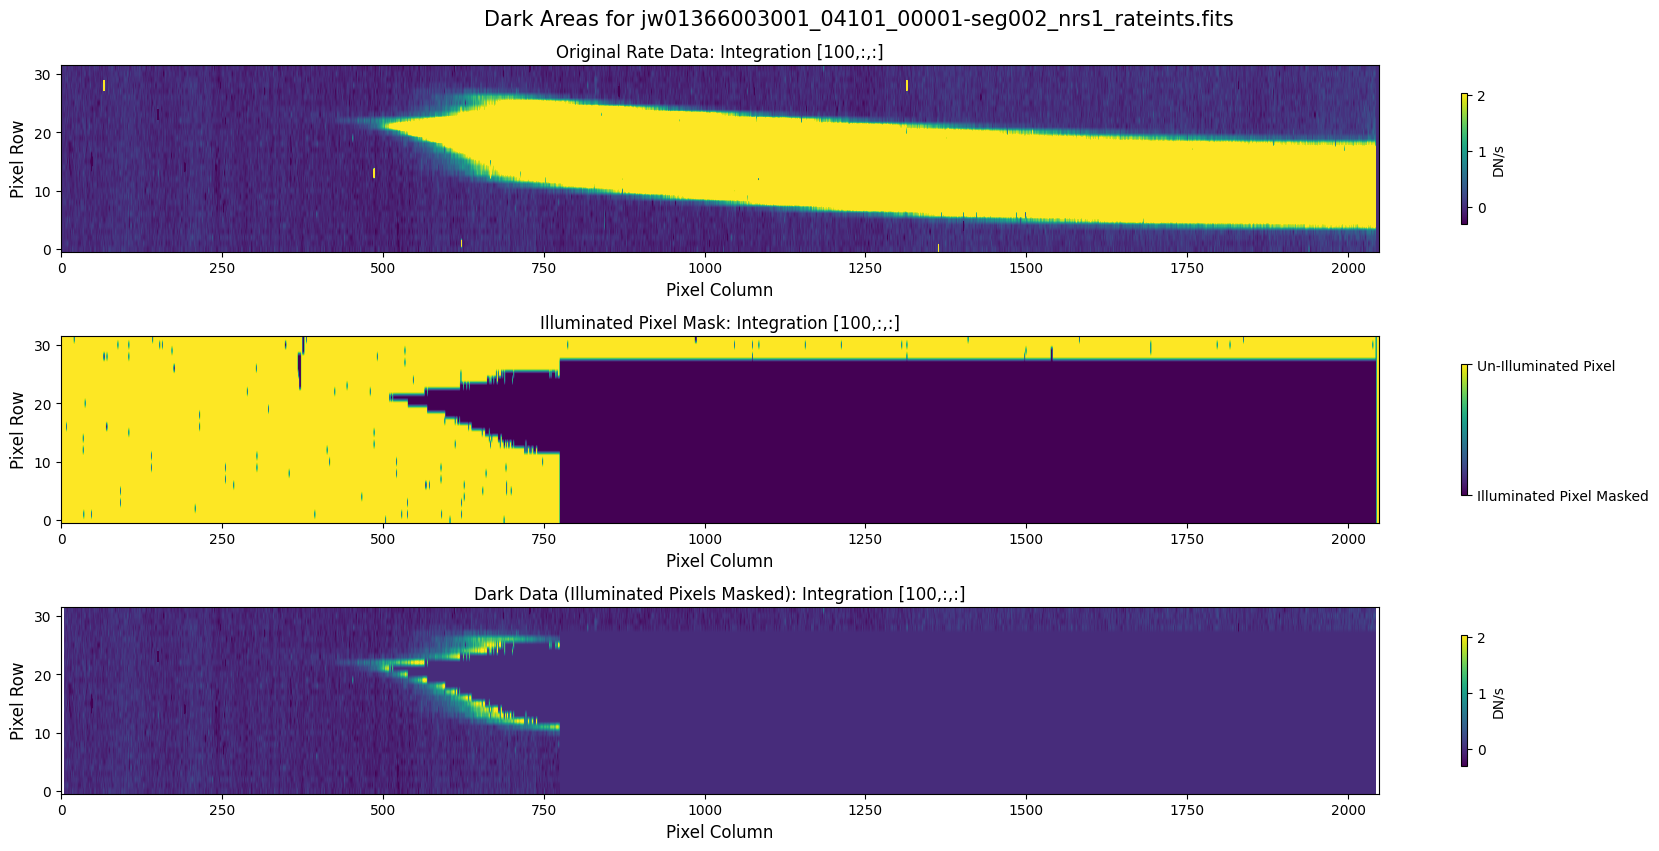

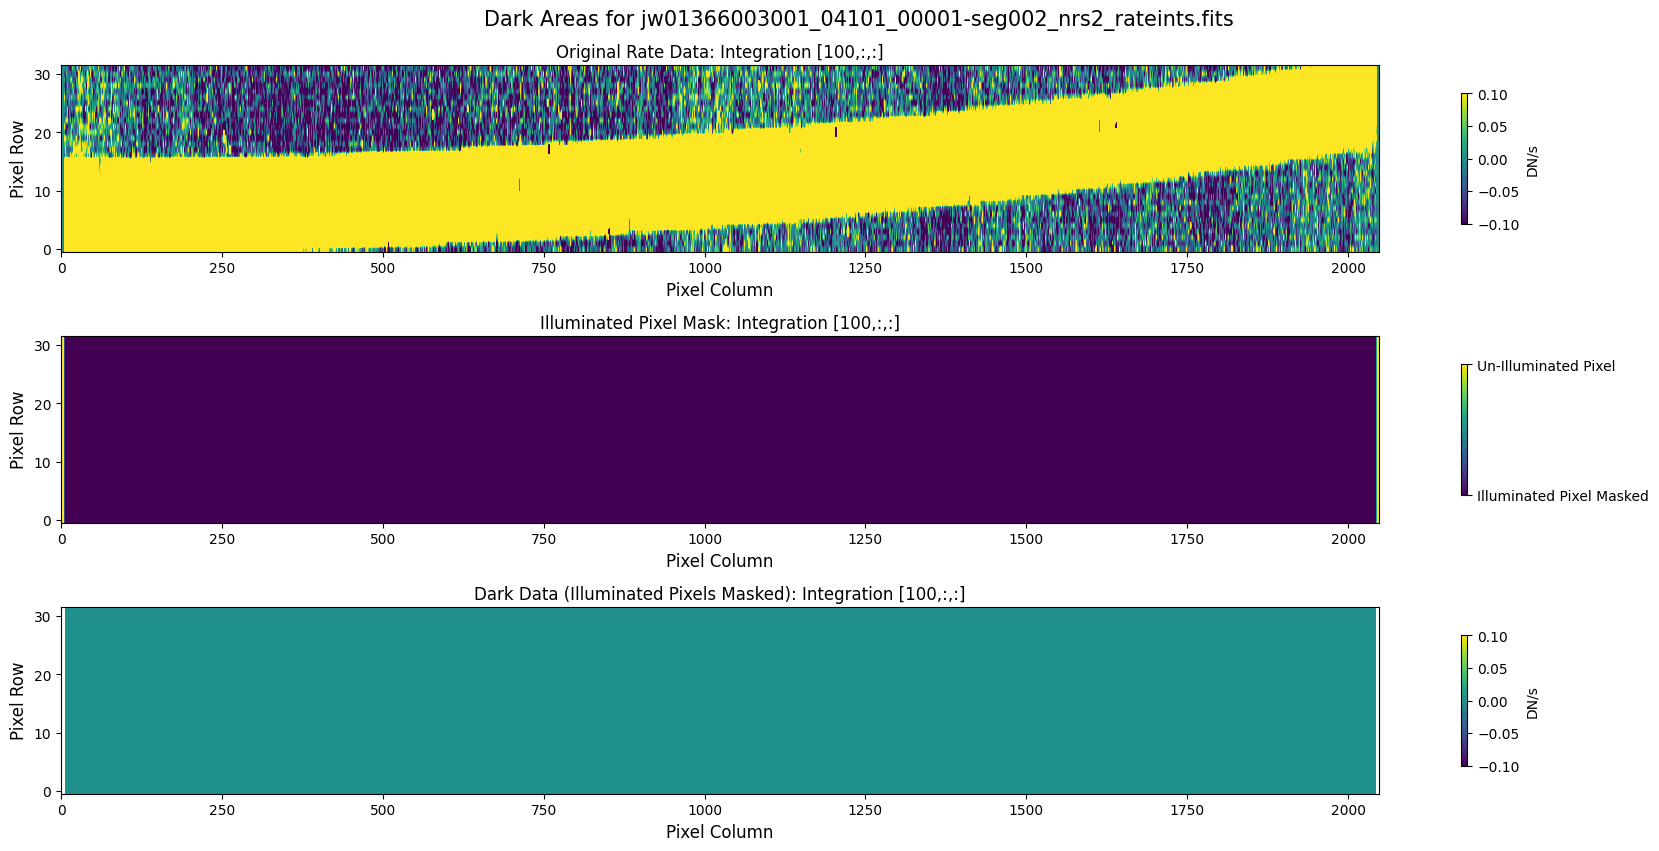

In [11]:
# Plot the rate data with masked areas blocked.

# List of on-the-fly built masks from the pipeline.
nsclean_default_masks = [
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs1_mask.fits",
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs2_mask.fits",
]

# Plot each associated set of rateint data and mask file.
for rateint_file, mask_file in zip(rateints_names, nsclean_default_masks):
    plot_dark_data(
        mast_products_dir + rateint_file,
        mask_file,
        slice_index=100,
        axis=0,
        layout="rows",
    )

The default pipeline mask for NRS2 masks the entire countrate image. 

### 5.2 Comparing Original vs. Cleaned Data (Default Pipeline Mask) <a name="nsclean_default_compare"></a>
<hr style="border:1px solid black">

We can now compare the cleaned data (with the default pipeline mask) to the original rate file and verify that the 1/f noise has been reduced.

In many cases, the cleaning process introduces new artifacts to the rate file. These should be carefully examined and weighed against the benefits of noise reduction. If transient artifacts, like snowballs, are interfering with the cleaning process, it may be beneficial to manually edit the mask to remove these areas from consideration in the background fit. To do so, try varying the outlier detection threshold or editing specific pixels in the mask array directly (explored in the next few sections). Otherwise, refer to the [NSClean documentation](https://iopscience.iop.org/article/10.1088/1538-3873/ad1b36/pdf) for additional suggestions on manual editing.

Note that in the images below, there are scattered values with large relative differences from the original rate file (shown in the relative difference image below). These are artifacts of the cleaning process.

There are also broader low-level residual background effects (shown in the relative difference image on the right, below, with scattered outliers, identified with sigma clipping, hidden by masking). These include the background patterns we are trying to remove: the 1/f noise variations in the dispersion direction and the picture frame effect at the top and bottom of the frame (for full-frame data). However, there may also be low-level artifacts introduced by over-fitting the dark data in the cleaning process.

Check both residual images carefully to understand the impact of the cleaning process on your data.

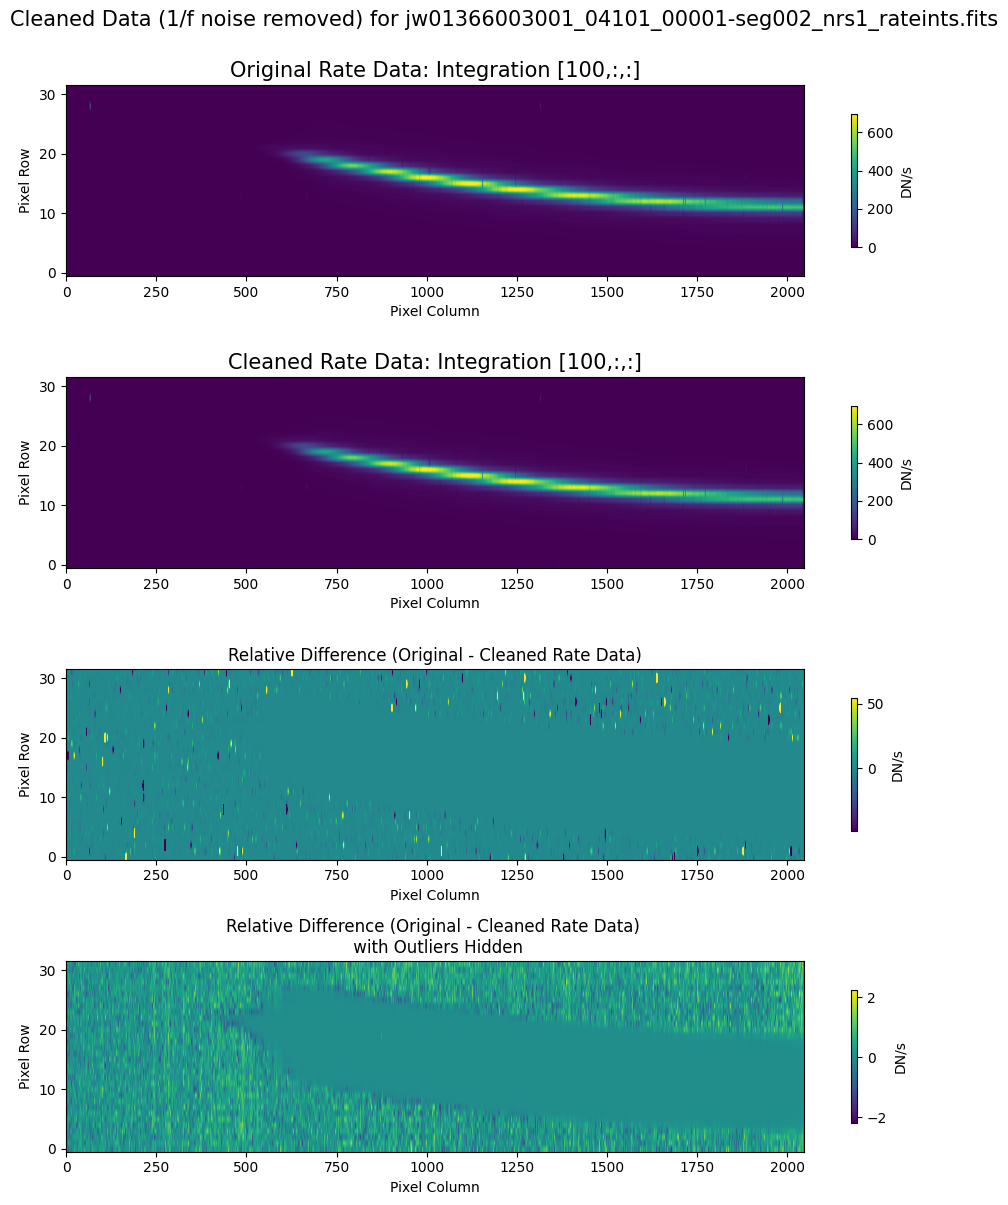

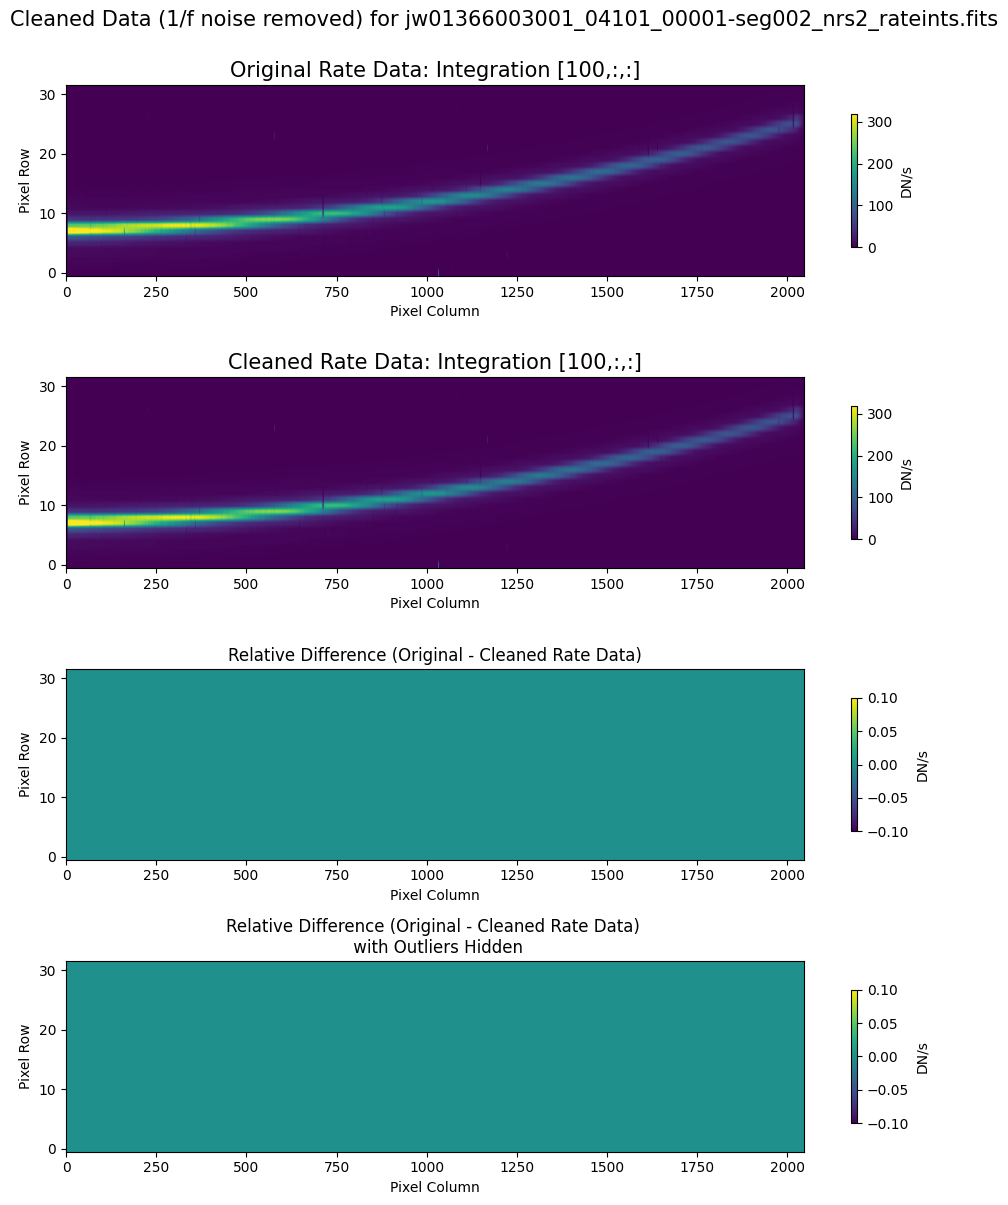

In [12]:
# Plot the original and cleaned data, as well as a residual map.

cleaned_default_masks = [
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs1_nsclean.fits",
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs2_nsclean.fits",
]

# Plot each associated set of rateint data and cleaned file.
for rateint_file, cleaned_file in zip(rateints_names, cleaned_default_masks):
    plot_cleaned_data(
        mast_products_dir + rateint_file, cleaned_file, slice_index=100, layout="rows"
    )

The default pipeline mask for NRS2 masks the entire countrate image so there is no difference when NSClean is applied. 

Compare the extracted spectrum from the cleaned data to the spectrum extracted from the original rate file.

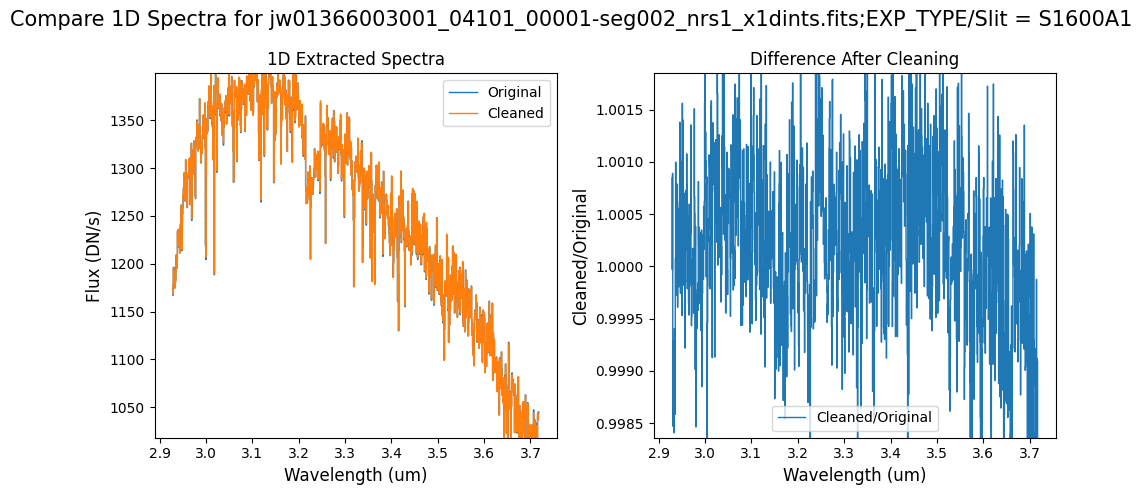

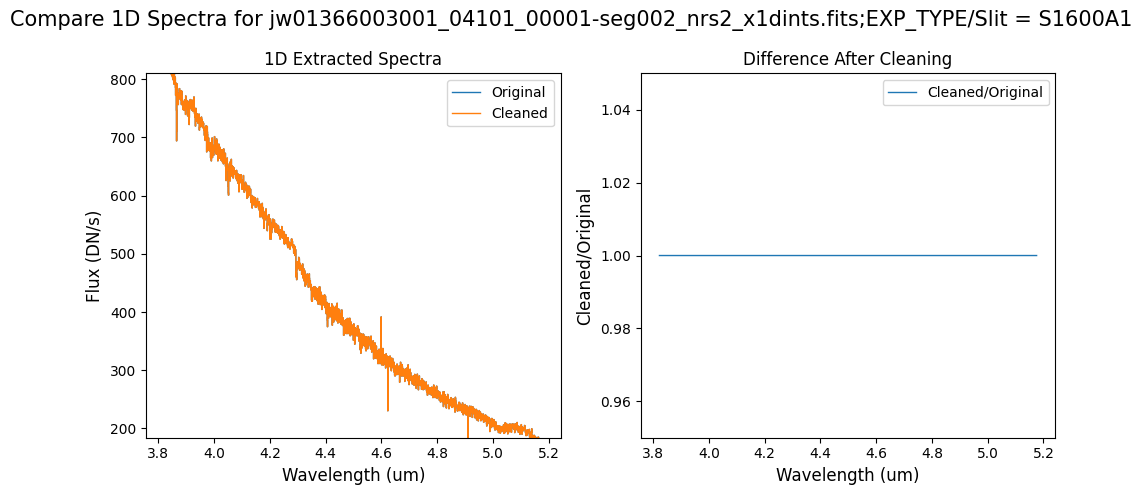

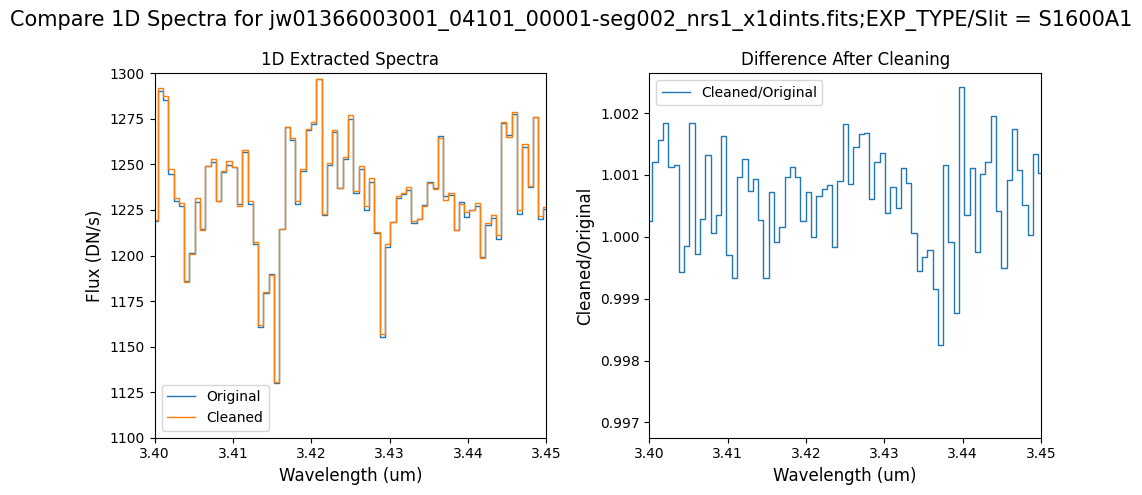

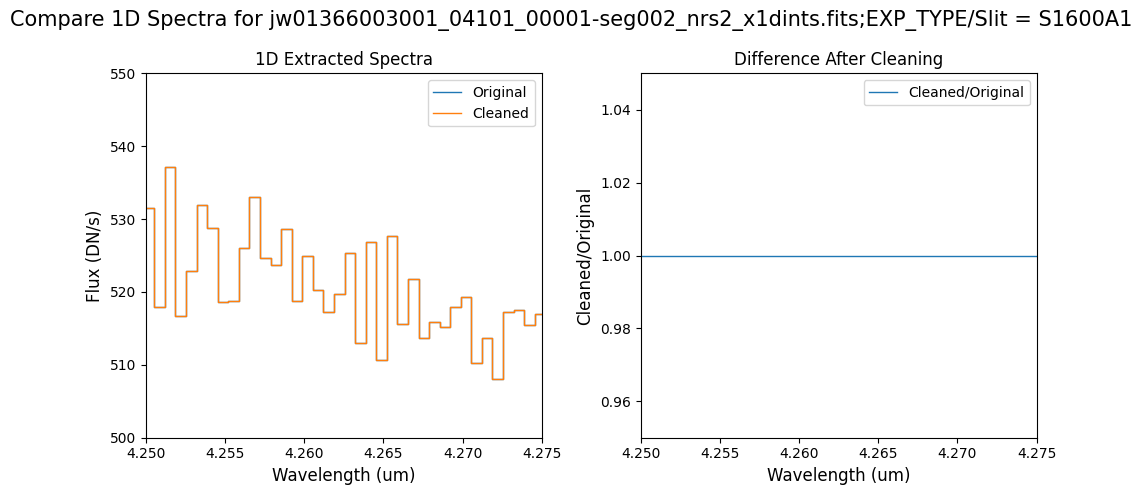

In [13]:
# Plot the entire spectra.

# 1D extracted spectra.
x1d_nsclean_skipped = [
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]
x1d_nsclean_default = [
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_default_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_default):
    plot_spectra([original, cleaned], ext_num=100)

# Wavelength/flux region of interest
wavelength_range = {"nrs1": [3.4, 3.45], "nrs2": [4.25, 4.275]}

flux_range = {"nrs1": [1100, 1300], "nrs2": [500, 550]}

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_default):
    plot_spectra(
        [original, cleaned],
        ext_num=100,
        scale_percent=0,
        wavelength_range=wavelength_range,
        flux_range=flux_range,
    )

<div class="alert alert-block alert-info">
<b>Notes:</b> 
    
* The bright spectrum in NRS1 shows little difference after cleaning.


* The default mask generated on-the-fly by the pipeline in NRS2 masks the entire science region, potentially over-masking dark areas that could enhance the background fit. This results in no discernible differences between the original and cleaned data for NRS2. In the following section, we explore the process of generating an alternative mask with the pipeline to address this issue.
</div>

## 6. Clean up 1/f Noise with NSClean (Alternate Mask) <a name="nsclean_alternate"></a>
<hr style="border:1px solid black">


For some data sets, masking the entire science region may excessively mask dark areas of the detector that could be used to improve the background fit.  Excessive masking can introduce some high frequency noise in the cleaning process that appears as vertical striping over the spectral traces. 

Also, for some data sets, there may be several illuminated regions of the detector that are not masked by the WCS bounding boxes.  In the subarray data, note that the mask does not cover the bluest end of the spectral trace.  This region is illuminated, but is not calibrated.

In some cases, it may be beneficial to build the mask with an alternate algorithm.  Here, we do not use the bounding boxes and instead iteratively mask any data more than 0.1 sigma above the background.  For bright sources, this leaves more dark data near the spectral trace and may improve the background fit. 

Note, however, that excessive cleaning may impact the continuum level for the spectrum, if too much or too little illuminated data is included in the mask. Again, the generated mask and output spectra should be carefully examined to weigh the benefits of cleaning against the impact on the spectra.

To tune the illumination detection in this mask, try modifying the `n_sigma` parameter below. A higher value will identify less illumination. A lower value will identify more.

In [14]:
# Set up directory for running NSClean with alternate parameters.
stage2_nsclean_alternate_dir = "./stage2_nsclean_alternate/"
if not os.path.exists(stage2_nsclean_alternate_dir):
    # Create the directory if it doesn't exist.
    os.makedirs(stage2_nsclean_alternate_dir)

In [15]:
# 1/f noise cleaned data (alternate NSClean pipeline mask).
# Estimated run time: 66 minutes (may vary).
start = tt.time()

for indx, i in enumerate(rateints_names):

    print(f"Processing {i}...")

    if "nrs1" in i:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs1_bots.json"
    else:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs2_bots.json"

    Spec2Pipeline.call(
        mast_products_dir + i,
        save_results=True,
        steps={
            # Assigns wavelength solution for spectroscopic data.
            "assign_wcs": {"skip": False, "save_results": True},
            # Removes correlated read noise (1/f noise) from NIRSpec images.
            "nsclean": {
                "skip": False,
                "save_mask": True,
                "n_sigma": 0.1,
                "mask_spectral_regions": False,
                "save_results": True,
            },
            "extract_2d": {"skip": False},  # Obtains 2D cutouts.
            "srctype": {"skip": False},  # Assigns source type: 'point' or 'extended'.
            # We opt to skip this step, because it can introduce spurious pixels
            # that can affect the light curve scatter.
            "flat_field": {"skip": True},
            # We also skip this step, because BOTS exoplanet observations are relative.
            "photom": {"skip": True},
            # Estimates the flux values of pixels flagged as DO_NOT_USE in 2-D spectra.
            "pixel_replace": {
                "skip": False,
                "n_adjacent_cols": 5,
                "algorithm": "fit_profile",
            },
            "extract_1d": {
                "skip": False,
                "override_extract1d": extract1dref,
                "apply_apcorr": False,
                "subtract_background": False,
            },
            # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
        },
        output_dir=stage2_nsclean_alternate_dir,
    )

    print(f"Saved {i[:-13]}" + "assign_wcs.fits")
    print(f"Saved {i[:-13]}" + "mask.fits")
    print(f"Saved {i[:-13]}" + "nsclean.fits")
    print(f"Saved {i[:-13]}" + "calints.fits")
    print(f"Saved {i[:-13]}" + "x1dints.fits")

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Processing jw01366003001_04101_00001-seg002_nrs1_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs1_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs1_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs1_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs1_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs1_x1dints.fits
Processing jw01366003001_04101_00001-seg002_nrs2_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs2_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs2_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs2_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs2_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs2_x1dints.fits
Run time:  54.873333333333335  min


### 6.1 Verify the Mask (Alternate Mask) <a name="verify_alternate_mask"></a>
<hr style="border:1px solid black">

Check the mask against the rate data to make sure it keeps only dark areas of the detector.


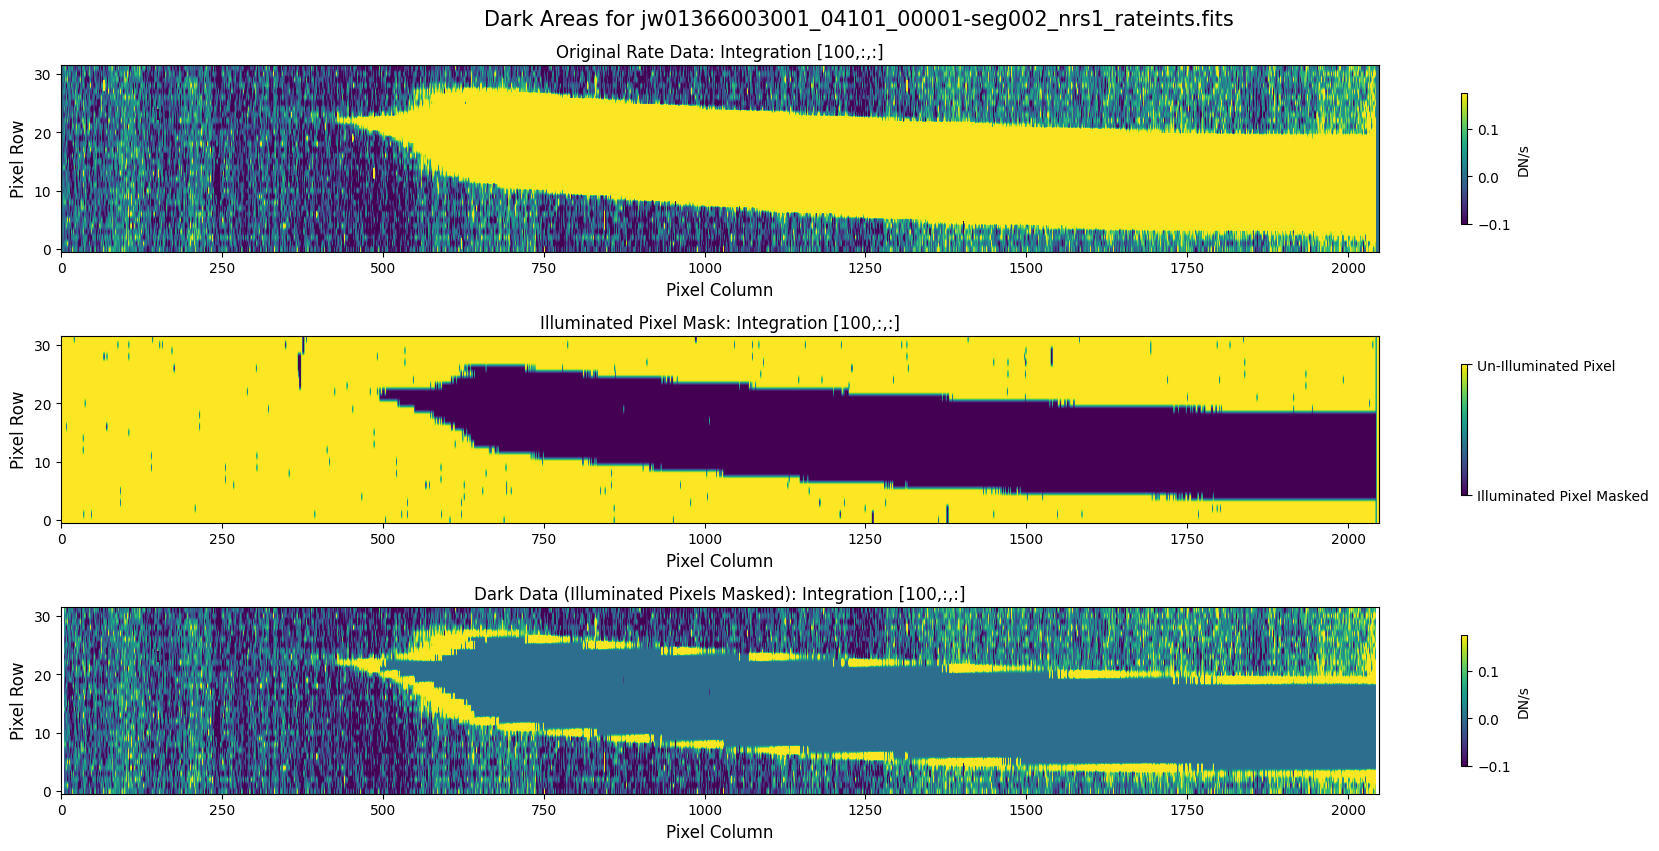

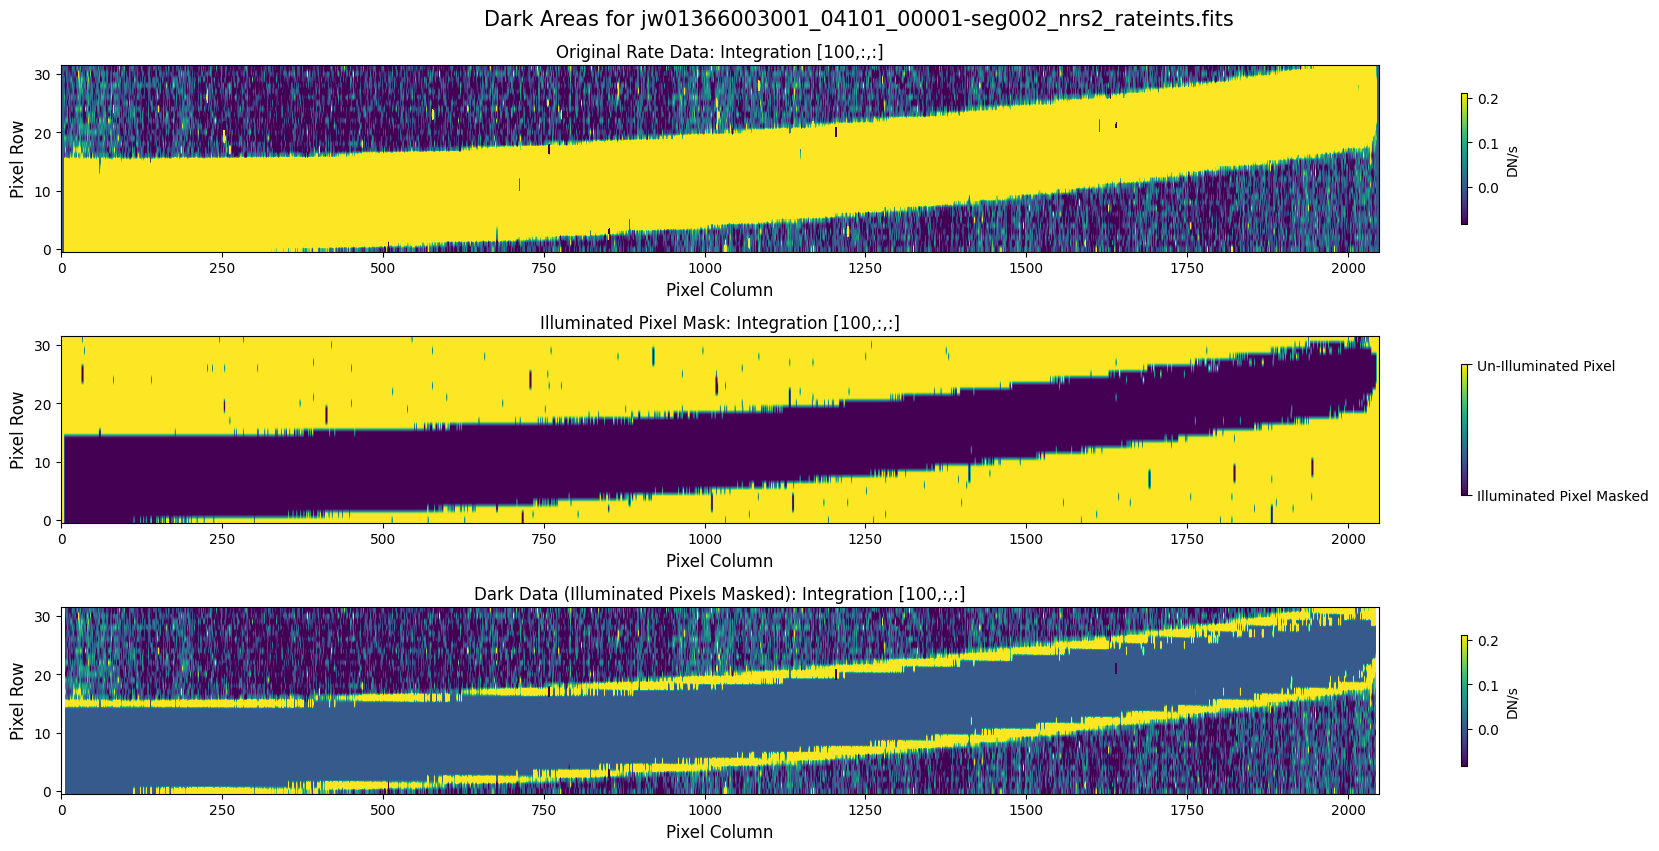

In [16]:
# Plot the rate data with masked areas blocked.

# List of on-the-fly built masks from the pipeline.
nsclean_alternate_masks = [
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs1_mask.fits",
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs2_mask.fits",
]

# Plot each associated set of rateint data and mask file.
for rateint_file, mask_file in zip(rateints_names, nsclean_alternate_masks):
    plot_dark_data(
        mast_products_dir + rateint_file, mask_file, slice_index=100, axis=0, scale=9
    )

### 6.2 Comparing Original vs. Cleaned Data (Alternate Mask) <a name="nsclean_alternate_compare"></a>
<hr style="border:1px solid black">

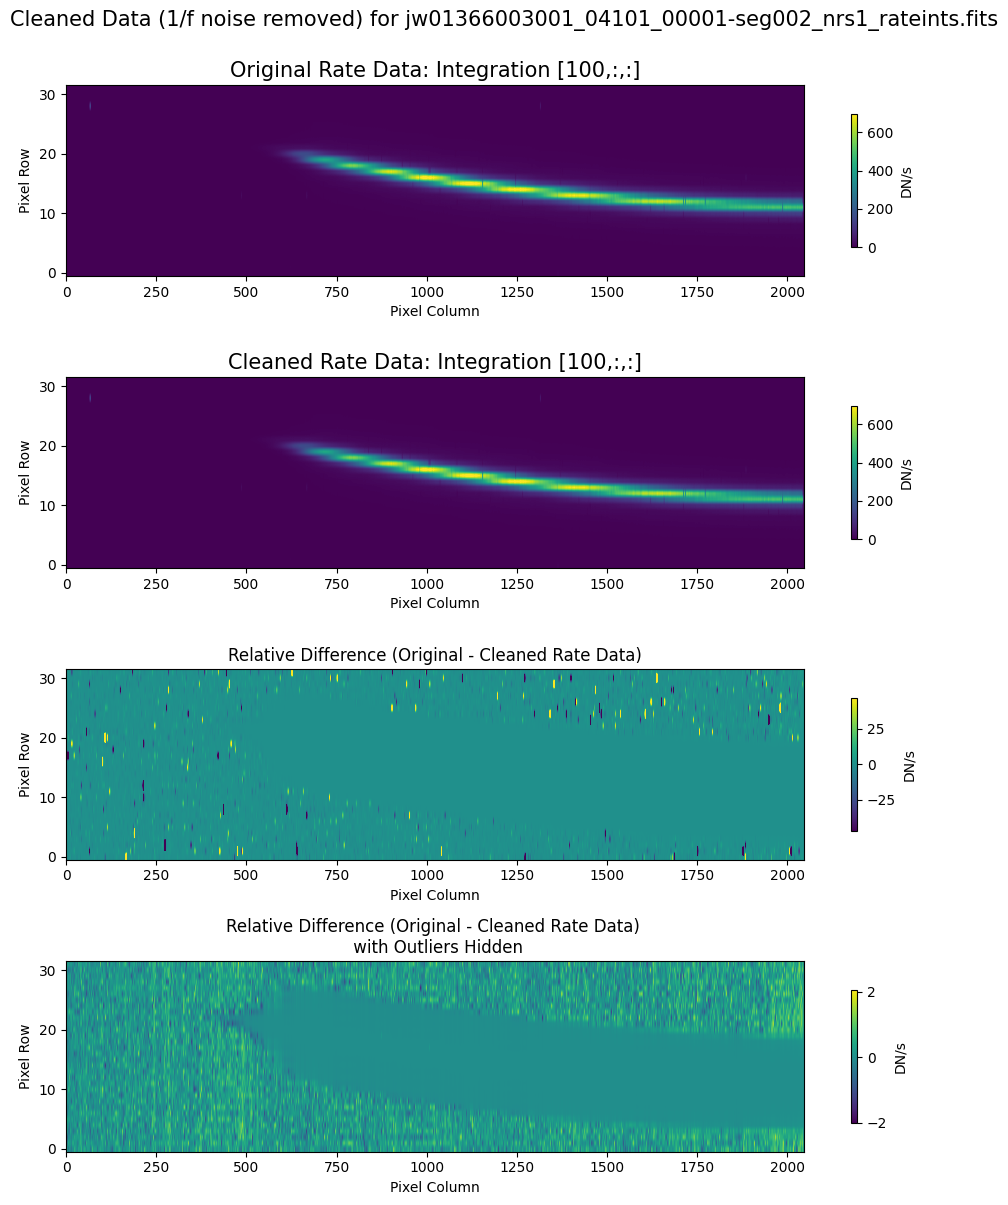

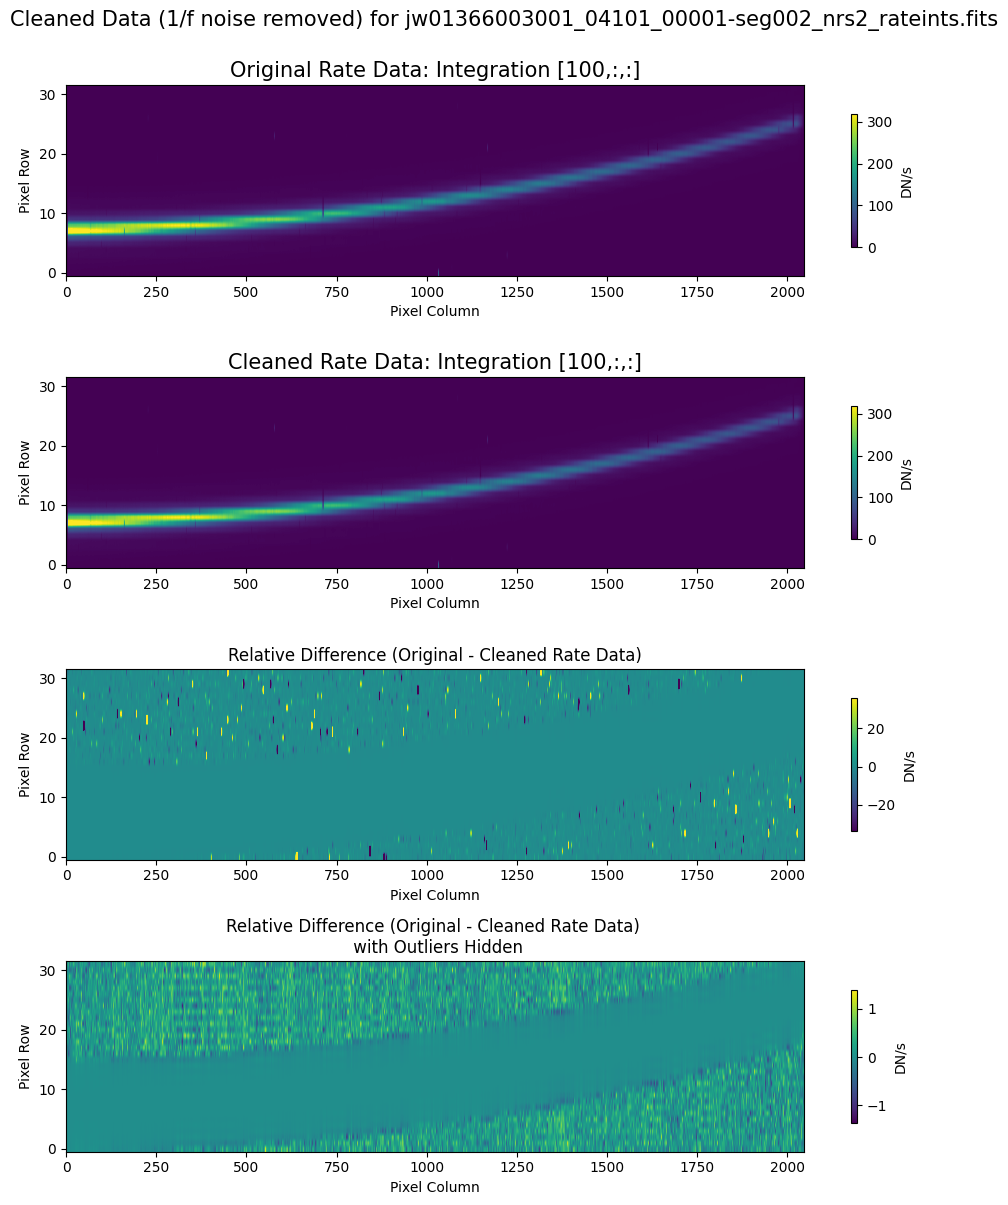

In [17]:
# Plot the original and cleaned data, as well as a residual map.

cleaned_alternate_masks = [
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs1_nsclean.fits",
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs2_nsclean.fits",
]

# Plot each associated set of rateint data and cleaned file.
for rateint_file, cleaned_file in zip(rateints_names, cleaned_alternate_masks):
    plot_cleaned_data(
        mast_products_dir + rateint_file, cleaned_file, slice_index=100, layout="rows"
    )

Compare the extracted spectrum from the cleaned data to the spectrum extracted from the original rate file.

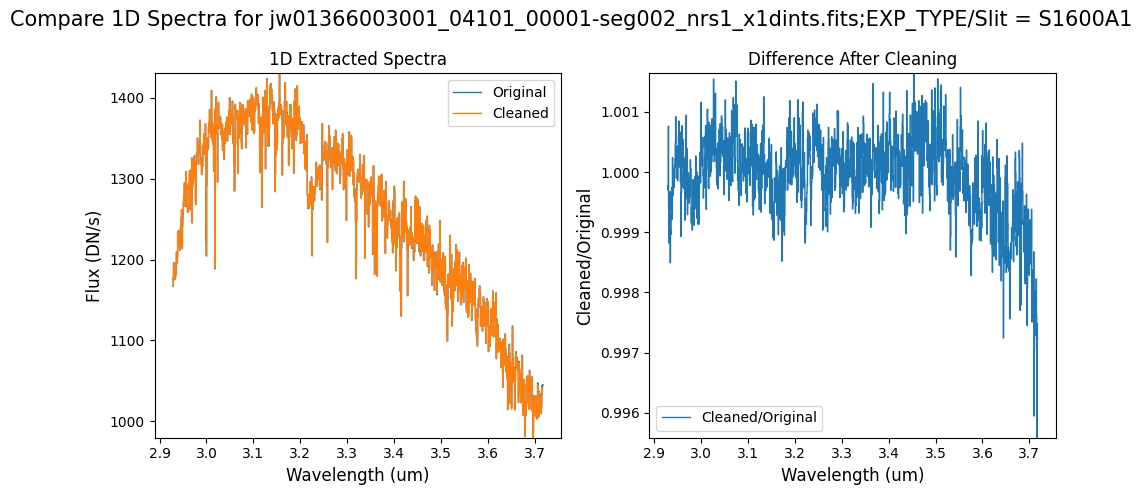

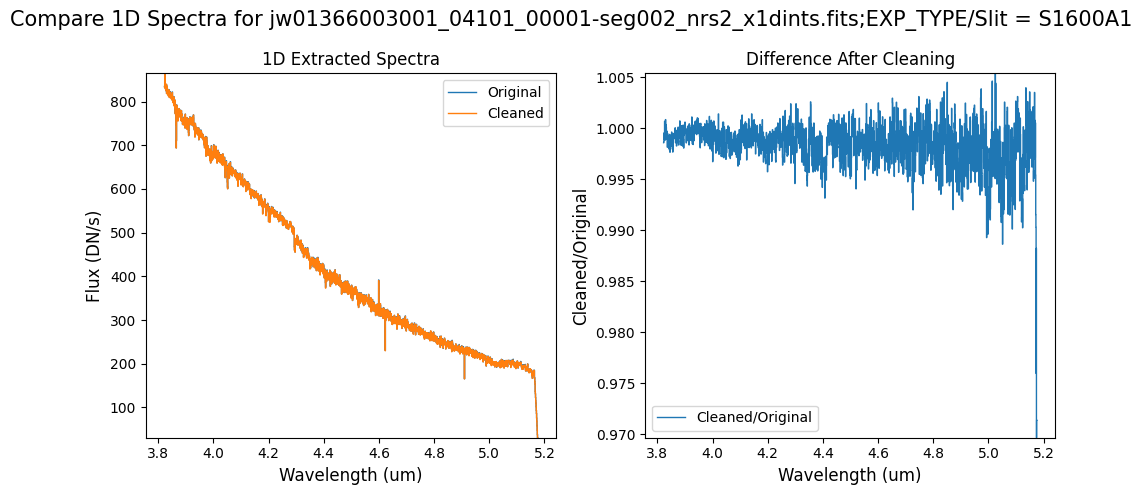

In [18]:
# 1D extracted spectra
x1d_nsclean_skipped = [
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]
x1d_nsclean_alternate = [
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_alternate_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_alternate):
    plot_spectra([original, cleaned], ext_num=100, scale_percent=0)

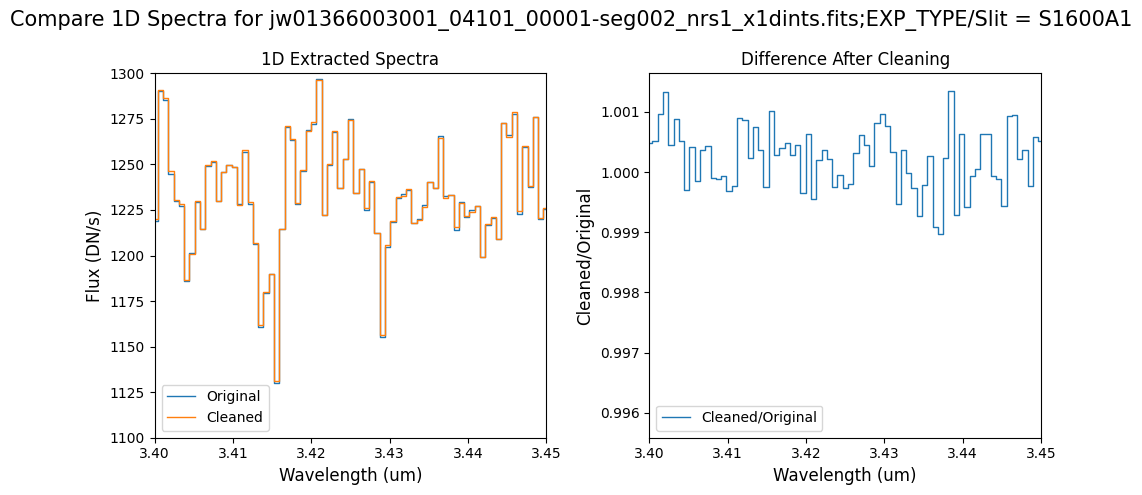

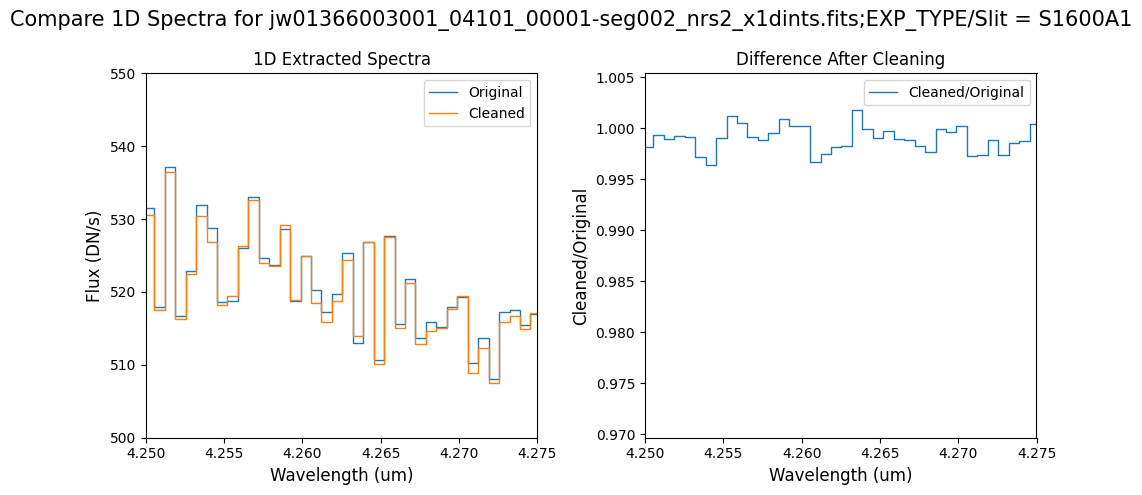

In [19]:
# Wavelength region of interest.
wavelength_range = {"nrs1": [3.4, 3.45], "nrs2": [4.25, 4.275]}
flux_range = {"nrs1": [1100, 1300], "nrs2": [500, 550]}

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_alternate):
    plot_spectra(
        [original, cleaned],
        ext_num=100,
        scale_percent=0,
        wavelength_range=wavelength_range,
        flux_range=flux_range,
    )

<div class="alert alert-block alert-info">
<b>Note:</b> The bright spectrum in NRS1/NRS2 shows little difference after cleaning. However, according to the ratio, the spectrum in NRS1 indicates that the cleaned data may have a slightly higher flux, whereas in NRS2, the cleaned data exhibits a slightly lower flux compared to the original data.
</div>

## 7. Clean up 1/f Noise with NSClean (Hand-Modified Mask) <a name="nsclean_modified"></a>
<hr style="border:1px solid black">

In certain scenarios, manual generation of a mask may be required. Here, we present **one** approach to manually modify the mask starting with the default mask output from the pipeline. It is worth noting that the mask modified using this method may not necessarily outperform the two previous options.

In [20]:
# Set up directory for running NSClean with user-supplied mask.
stage2_nsclean_modified_dir = "./stage2_nsclean_modified/"
if not os.path.exists(stage2_nsclean_modified_dir):
    # Create the directory if it doesn't exist.
    os.makedirs(stage2_nsclean_modified_dir)

In [21]:
# Hand-modify certain mask regions.

# Define the list to store paths of modified masks.
nsclean_modified_masks = []

# Iterate through the list of original masks.
for mask in nsclean_default_masks:
    # New mask file name.
    output_file = os.path.basename(mask)[:-5] + "_modified.fits"

    # Open the FITS file.
    with fits.open(mask) as hdul:
        # Extract the mask data from the science extension.
        mask_data = hdul["SCI"].data.copy()  # Make a copy.

        # Step 1: Set the default masked regions back to True.
        mask_data[:, :, :] = True

        # Step 2: Re-define masked regions by hand.
        if "nrs1" in mask:
            mask_data[:, 11:29, 400:700] = False
            mask_data[:, 10:27, 700:800] = False
            mask_data[:, 8:26, 800:1000] = False
            mask_data[:, 7:24, 1000:1200] = False
            mask_data[:, 4:23, 1200:1400] = False
            mask_data[:, 4:22, 1400:1600] = False
            mask_data[:, 3:21, 1600:2043] = False
        else:
            mask_data[:, :16, :290] = False
            mask_data[:, 1:18, 290:740] = False
            mask_data[:, 2:22, 740:1290] = False
            mask_data[:, 8:29, 1290:1840] = False
            mask_data[:, 11:, 1840:] = False

        # Update the data within the science extension.
        hdul["SCI"].data = mask_data
        # Save the modified FITS file.
        output_path = os.path.join(stage2_nsclean_modified_dir, output_file)
        hdul_modified = hdul.copy()  # Make a copy.
        hdul_modified.writeto(output_path, overwrite=True)
        nsclean_modified_masks.append(output_path)
        print(f"Saved modified mask as: {output_path}")

Saved modified mask as: ./stage2_nsclean_modified/jw01366003001_04101_00001-seg002_nrs1_mask_modified.fits
Saved modified mask as: ./stage2_nsclean_modified/jw01366003001_04101_00001-seg002_nrs2_mask_modified.fits


### 7.1 Verify the Mask (Hand-Modified Mask) <a name="verify_modified_mask"></a>
<hr style="border:1px solid black">

Check the mask against the rate data to make sure it keeps only dark areas of the detector.


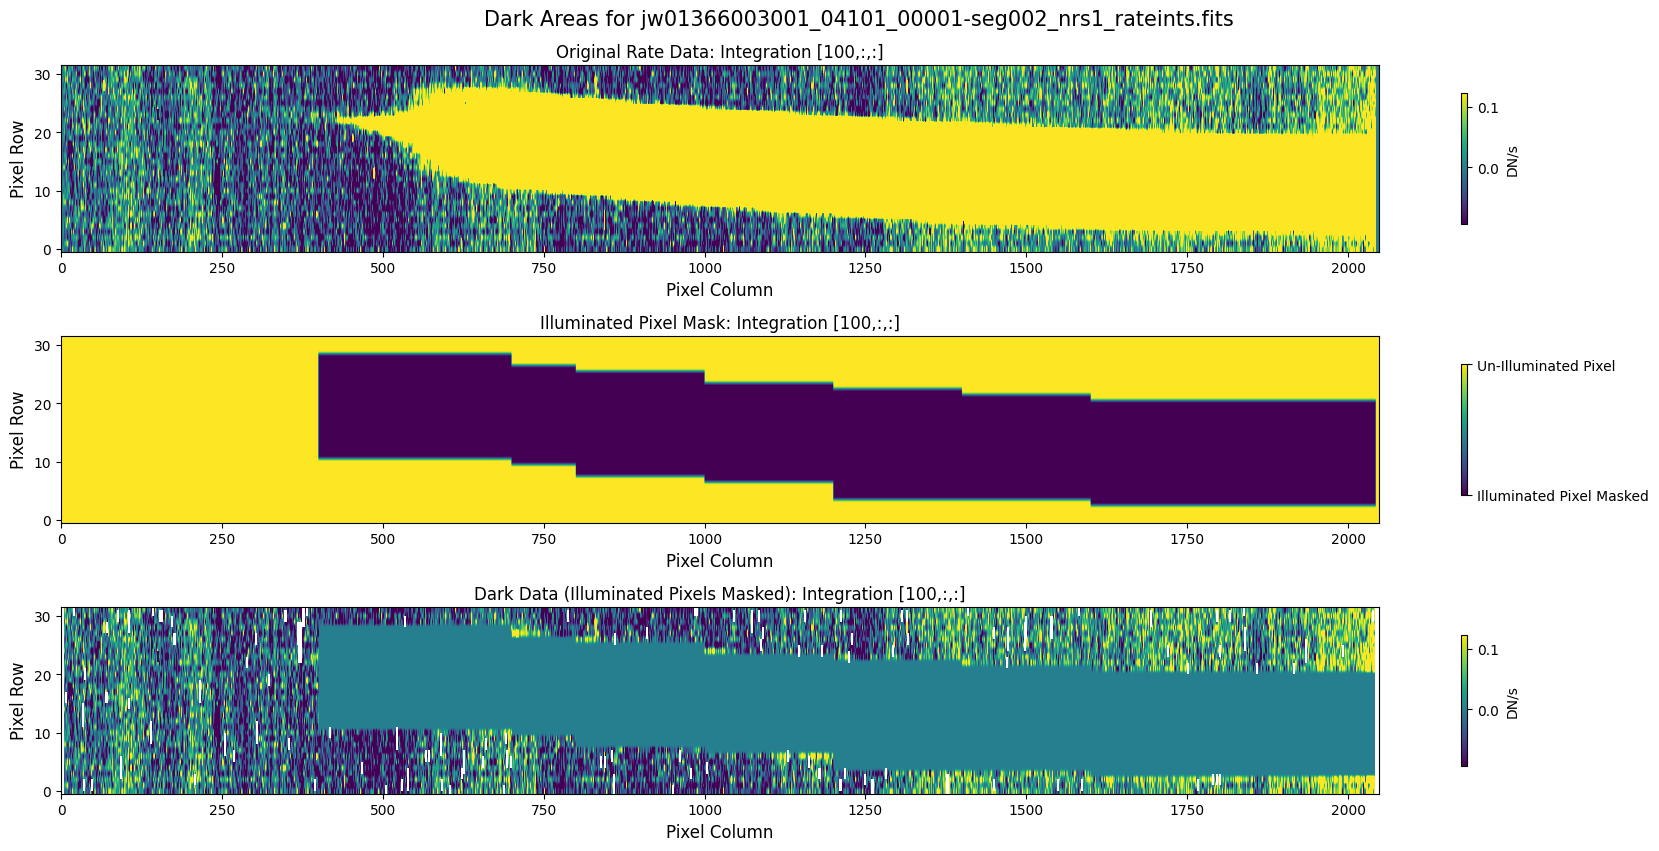

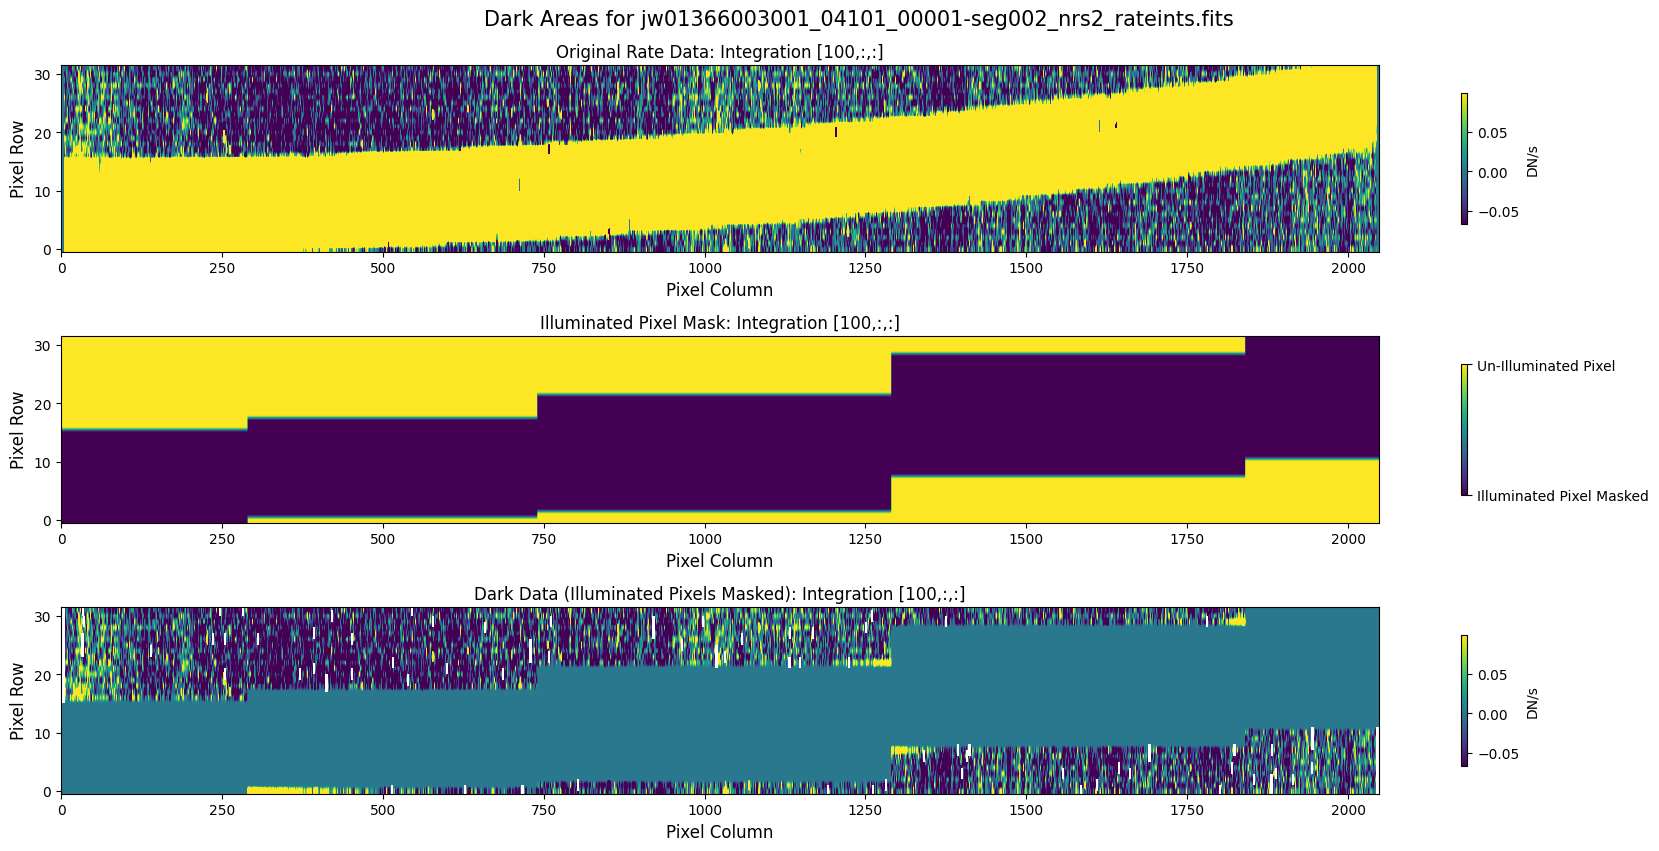

In [22]:
# Plot the rate data with masked areas blocked.

# List of modified masks for the pipeline.
nsclean_modified_masks = [
    stage2_nsclean_modified_dir
    + "jw01366003001_04101_00001-seg002_nrs1_mask_modified.fits",
    stage2_nsclean_modified_dir
    + "jw01366003001_04101_00001-seg002_nrs2_mask_modified.fits",
]

# Plot each associated set of rateint data and mask file.
for rateint_file, mask_file in zip(rateints_names, nsclean_modified_masks):
    plot_dark_data(
        mast_products_dir + rateint_file, mask_file, slice_index=100, axis=0, scale=9
    )

<hr style="border:1px solid black">


In [23]:
# 1/f noise cleaned data (user-supplied mask).
# Estimated run time: 57 minutes (may vary).
start = tt.time()

for indx, i in enumerate(rateints_names):

    print(f"Processing {i}...")

    if "nrs1" in i:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs1_bots.json"
    else:
        extract1dref = os.path.basename(extract_1d_ref)[:-5] + "_nrs2_bots.json"

    Spec2Pipeline.call(
        mast_products_dir + i,
        save_results=True,
        steps={
            # Assigns wavelength solution for spectroscopic data.
            "assign_wcs": {"skip": False, "save_results": True},
            # Removes correlated read noise (1/f noise) from NIRSpec images.
            "nsclean": {
                "skip": False,
                "save_mask": True,
                "save_results": True,
                "user_mask": nsclean_modified_masks[indx],
            },
            "extract_2d": {"skip": False},  # Obtains 2D cutouts.
            "srctype": {"skip": False},  # Assigns source type: 'point' or 'extended'.
            # We opt to skip this step, because it can introduce spurious pixels
            # that can affect the light curve scatter.
            "flat_field": {"skip": True},
            # We also skip this step, because BOTS exoplanet observations are relative.
            "photom": {"skip": True},
            # Estimates the flux values of pixels flagged as DO_NOT_USE in 2-D spectra.
            "pixel_replace": {
                "skip": False,
                "n_adjacent_cols": 5,
                "algorithm": "fit_profile",
            },
            "extract_1d": {
                "skip": False,
                "override_extract1d": extract1dref,
                "apply_apcorr": False,
                "subtract_background": False,
            },
            # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
        },
        output_dir=stage2_nsclean_modified_dir,
    )

    print(f"Saved {i[:-13]}" + "assign_wcs.fits")
    print(f"Saved {i[:-13]}" + "mask.fits")
    print(f"Saved {i[:-13]}" + "nsclean.fits")
    print(f"Saved {i[:-13]}" + "calints.fits")
    print(f"Saved {i[:-13]}" + "x1dints.fits")

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

Processing jw01366003001_04101_00001-seg002_nrs1_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs1_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs1_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs1_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs1_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs1_x1dints.fits
Processing jw01366003001_04101_00001-seg002_nrs2_rateints.fits...


Saved jw01366003001_04101_00001-seg002_nrs2_assign_wcs.fits
Saved jw01366003001_04101_00001-seg002_nrs2_mask.fits
Saved jw01366003001_04101_00001-seg002_nrs2_nsclean.fits
Saved jw01366003001_04101_00001-seg002_nrs2_calints.fits
Saved jw01366003001_04101_00001-seg002_nrs2_x1dints.fits
Run time:  46.665  min


### 7.2 Comparing Original vs. Cleaned Data (Hand-Modified Mask) <a name="nsclean_modified_compare"></a>
<hr style="border:1px solid black">

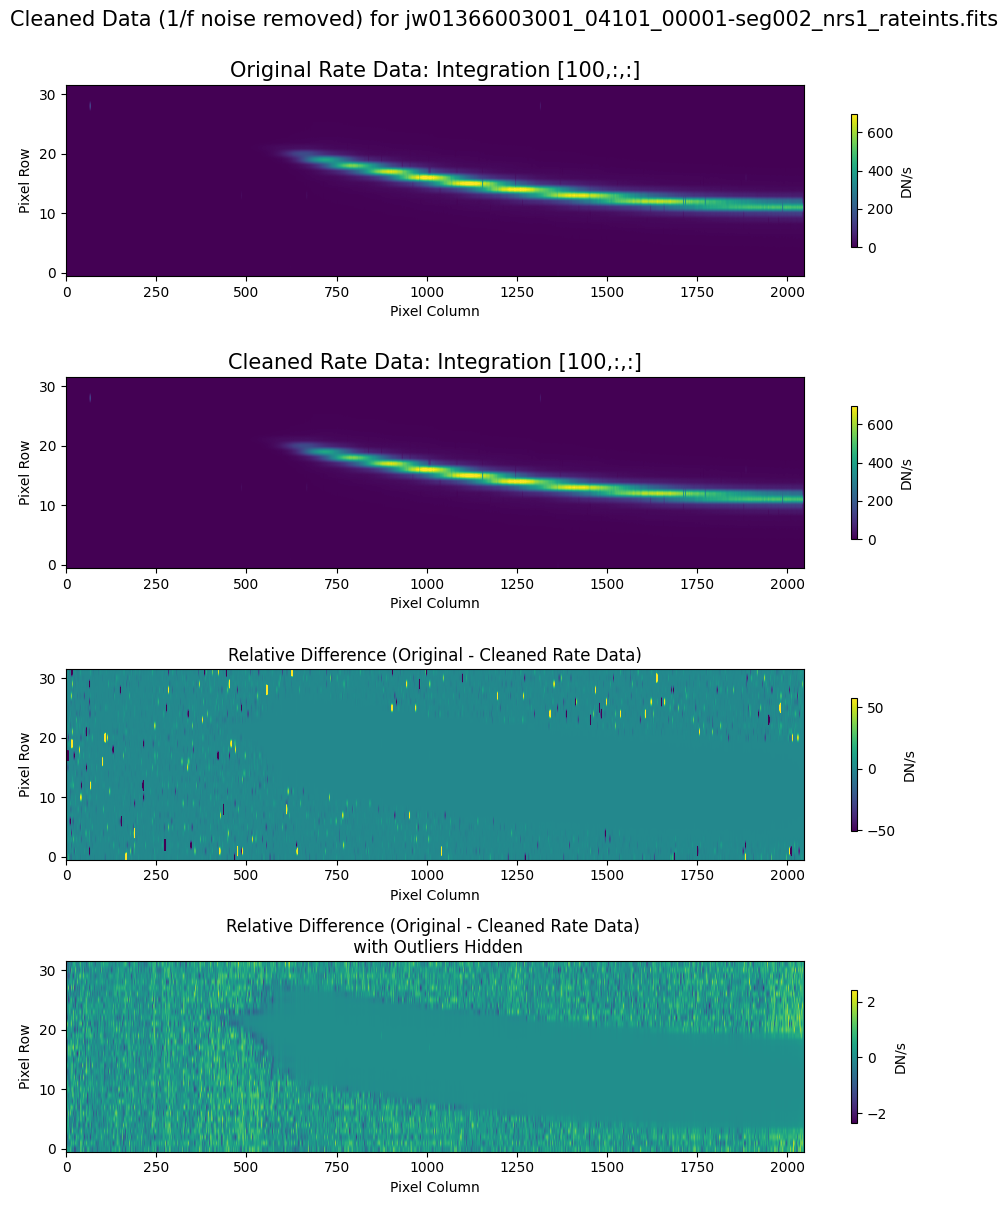

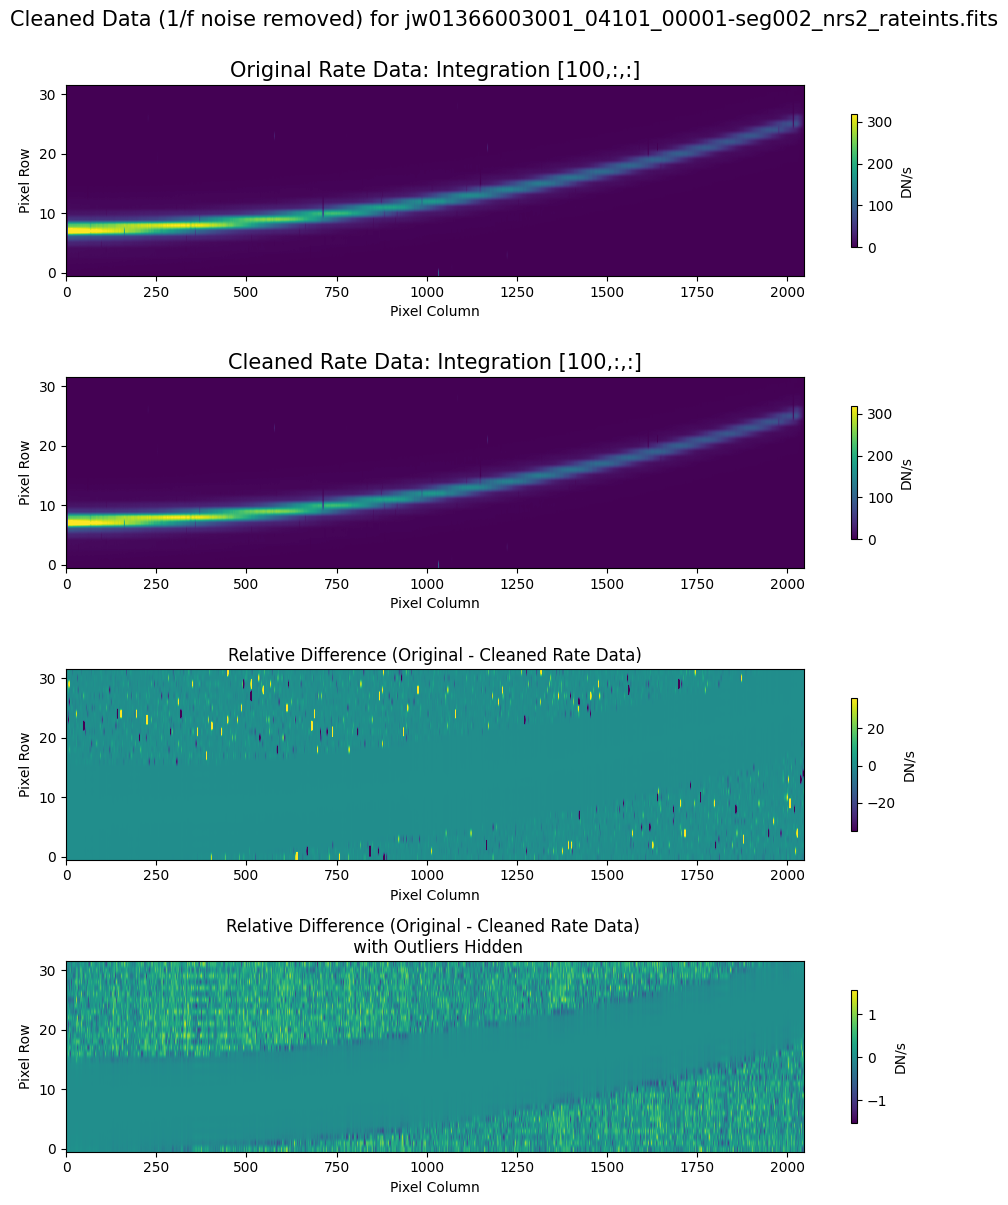

In [24]:
# Plot the original and cleaned data, as well as a residual map.

cleaned_modified_masks = [
    stage2_nsclean_modified_dir + "jw01366003001_04101_00001-seg002_nrs1_nsclean.fits",
    stage2_nsclean_modified_dir + "jw01366003001_04101_00001-seg002_nrs2_nsclean.fits",
]

# Plot each associated set of rateint data and cleaned file
for rateint_file, cleaned_file in zip(rateints_names, cleaned_modified_masks):
    plot_cleaned_data(
        mast_products_dir + rateint_file, cleaned_file, slice_index=100, layout="rows"
    )

Compare the extracted spectrum from the cleaned data to the spectrum extracted from the original rate file. 

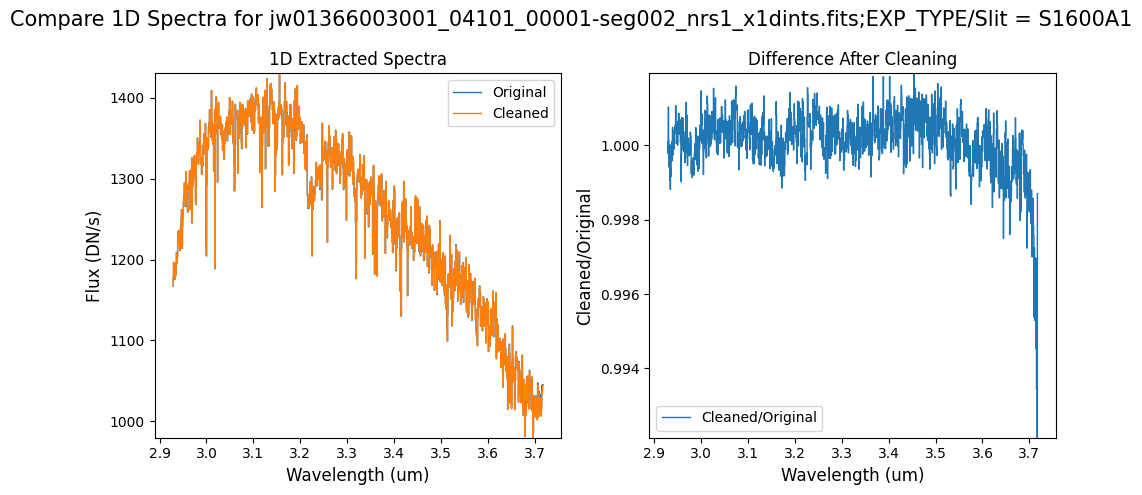

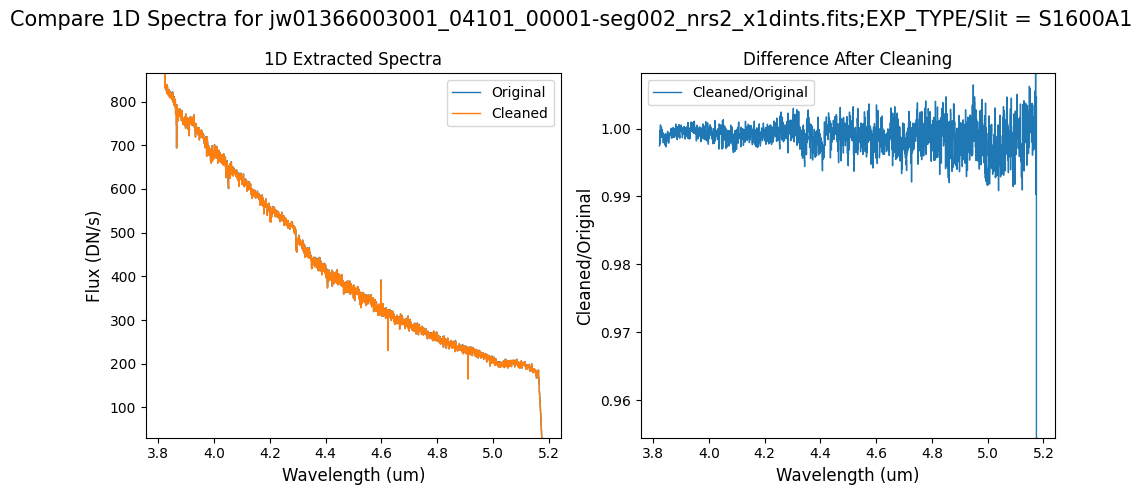

In [25]:
# 1D extracted spectra.
x1d_nsclean_skipped = [
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_skipped_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]
x1d_nsclean_modified = [
    stage2_nsclean_modified_dir + "jw01366003001_04101_00001-seg002_nrs1_x1dints.fits",
    stage2_nsclean_modified_dir + "jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
]

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_modified):
    plot_spectra([original, cleaned], ext_num=100, scale_percent=0)

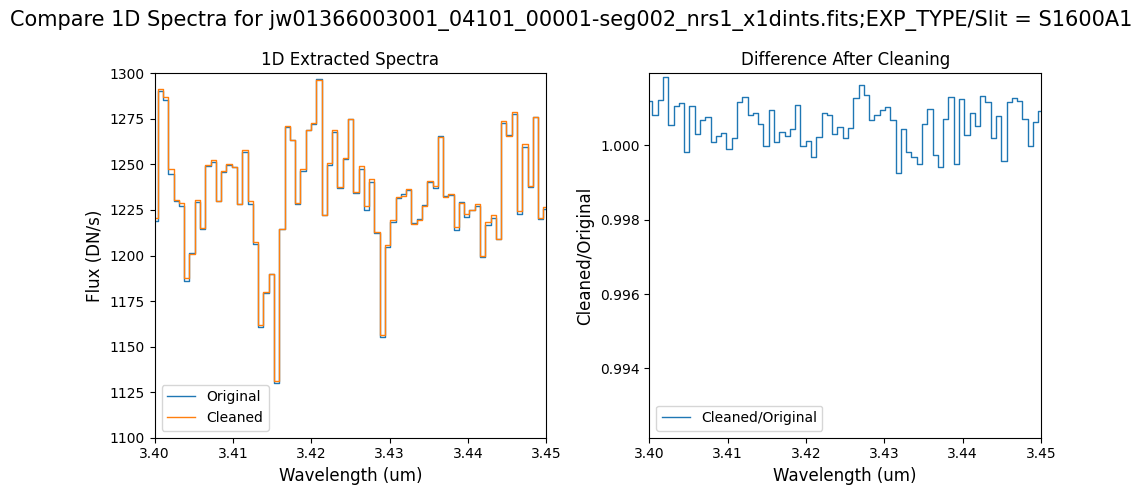

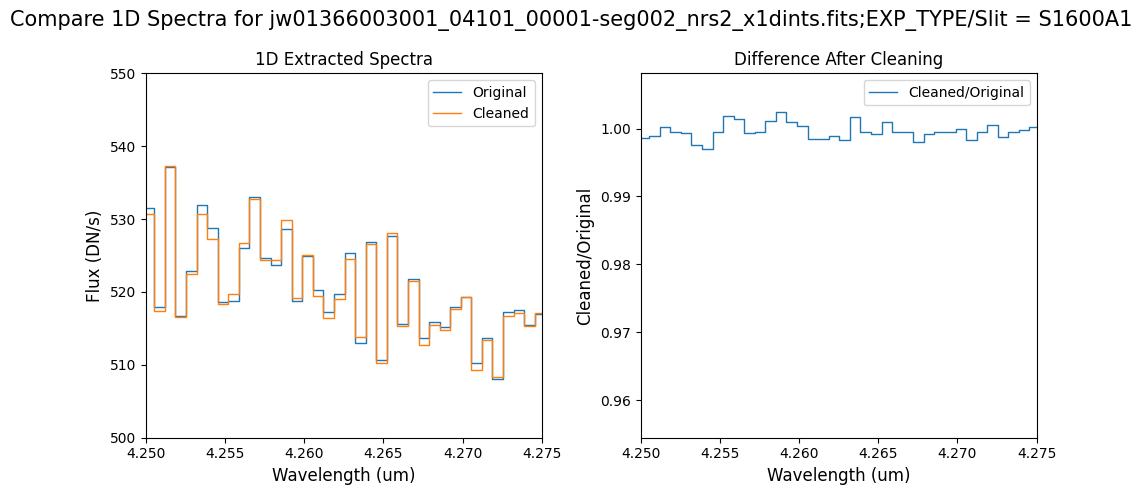

In [26]:
# Wavelength Region of interest.
wavelength_range = {"nrs1": [3.4, 3.45], "nrs2": [4.25, 4.275]}
flux_range = {"nrs1": [1100, 1300], "nrs2": [500, 550]}

for original, cleaned in zip(x1d_nsclean_skipped, x1d_nsclean_modified):
    plot_spectra(
        [original, cleaned],
        ext_num=100,
        scale_percent=0,
        wavelength_range=wavelength_range,
        flux_range=flux_range,
    )

<div class="alert alert-block alert-info">
<b>Note:</b> Once more, the bright spectrum in NRS1/NRS2 shows little difference after cleaning. However, according to the ratio, the spectrum in NRS1 indicates that the cleaned data may have a slightly higher flux, whereas in NRS2, the cleaned data exhibits a slightly lower flux compared to the original data.
</div>

## 8. Conclusion <a name="conclusion"></a>
<hr style="border:1px solid black">

The final plots below show the countrate images and the resulting 1D extracted spectra side-by-side to compare the different cleaning methods: the original (no NSClean applied), the cleaned countrate image (with the default pipeline mask), the cleaned countrate image (with an alternate pipeline mask), and finally, the cleaned countrate image (with the hand-modified mask).

Please note that the results presented in this notebook may vary for different datasets (e.g., targets of different brightness, spatial extent, etc.). Users are encouraged to explore NSClean using different masking methods to determine the optimal results.

The output from the cleaning algorithm is now ready for further processing.  The (*_calint.fits*) files produced by the above `Spec2Pipeline` run may be used as input to the `TSO3Pipeline`, for generating final combined spectra.

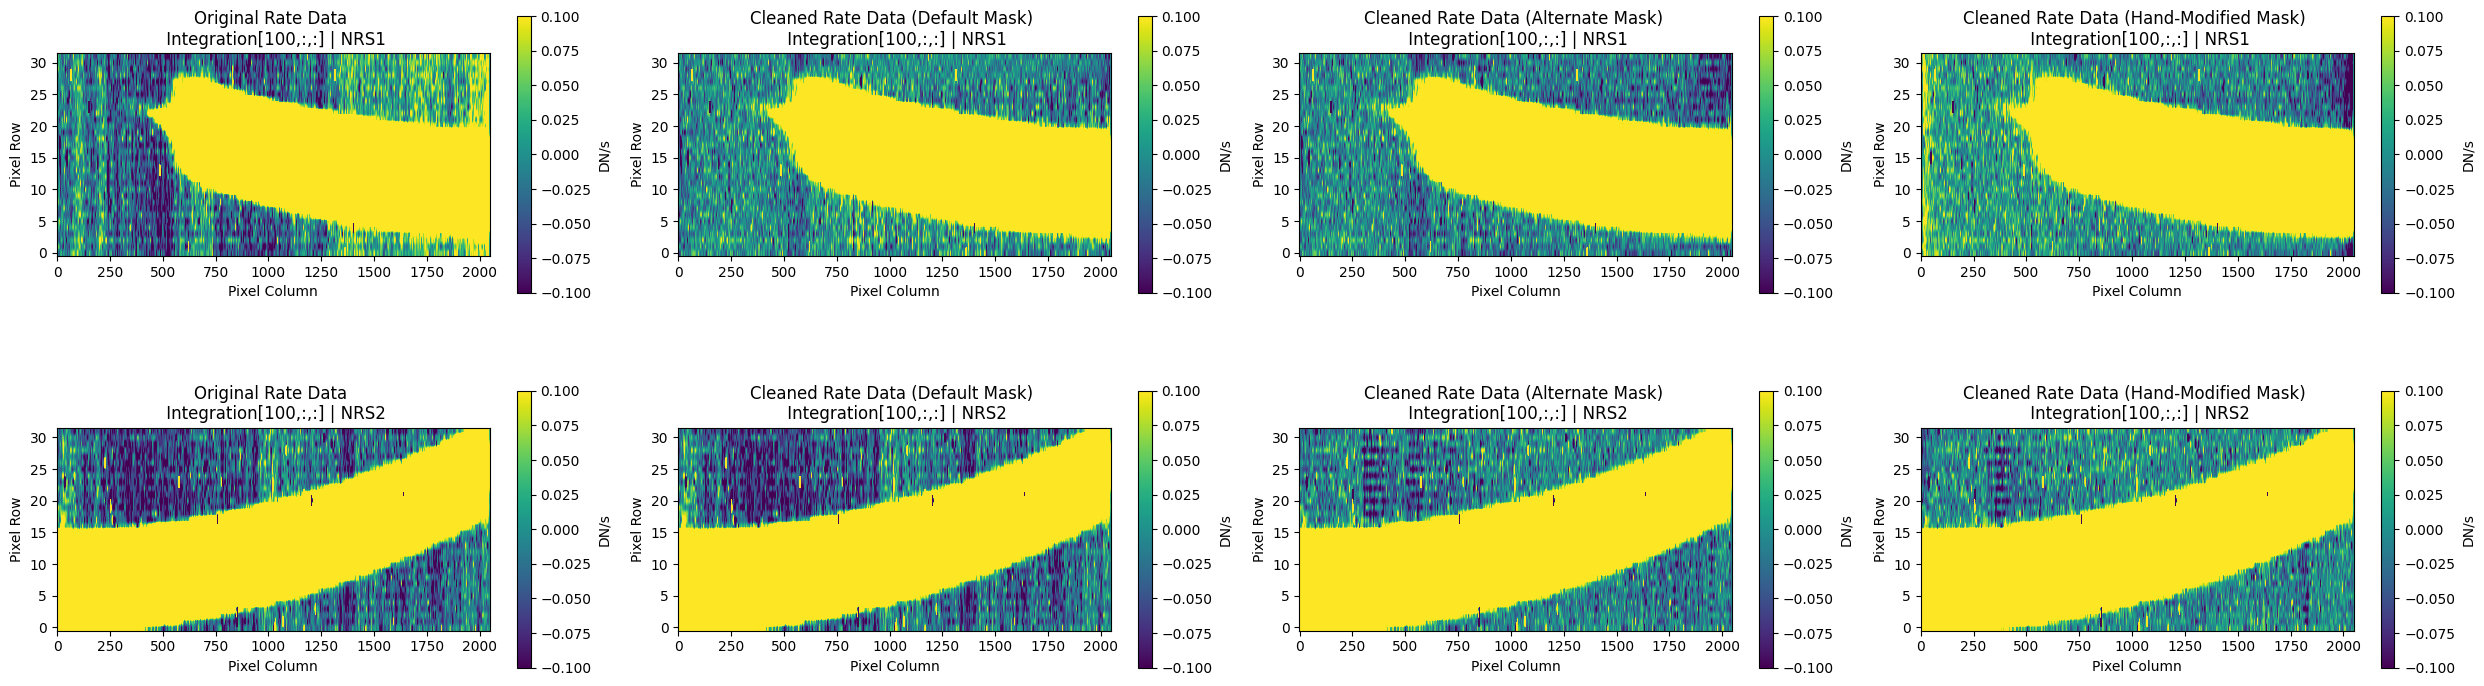

In [27]:
# Not cleaned vs. cleaned (default mask) vs. cleaned (alternate mask) rate data
original_rate_data = [
    fits.open(mast_products_dir + rate_name)[1].data[100, :, :]
    for rate_name in rateints_names
]
cleaned_rate_default_data = [
    fits.open(cleaned_default_mask)[1].data[100, :, :]
    for cleaned_default_mask in cleaned_default_masks
]
cleaned_rate_alternate_data = [
    fits.open(cleaned_alternate_mask)[1].data[100, :, :]
    for cleaned_alternate_mask in cleaned_alternate_masks
]
cleaned_rate_modified_data = [
    fits.open(cleaned_modified_mask)[1].data[100, :, :]
    for cleaned_modified_mask in cleaned_modified_masks
]

# For plotting visualization
for data_list in [
    original_rate_data,
    cleaned_rate_default_data,
    cleaned_rate_alternate_data,
    cleaned_rate_modified_data,
]:
    for data in data_list:
        data[np.isnan(data)] = 0

# Original vs. cleaned data (with default mask)
fig, axs = plt.subplots(2, 4, figsize=(25, 8))

# Set y-axis titles and plot the data
titles = [
    "Original Rate Data",
    "Cleaned Rate Data (Default Mask)",
    "Cleaned Rate Data (Alternate Mask)",
    "Cleaned Rate Data (Hand-Modified Mask)",
]
for i, (data_list, title) in enumerate(
    zip(
        [
            original_rate_data,
            cleaned_rate_default_data,
            cleaned_rate_alternate_data,
            cleaned_rate_modified_data,
        ],
        titles,
    )
):
    for j, data in enumerate(data_list):
        ax = axs[j, i]
        if j == 0:
            ax.set_title(f'{title} \n {"Integration[100,:,:] | NRS1"}', fontsize=12)
        else:
            ax.set_title(f'{title} \n {"Integration[100,:,:] | NRS2"}', fontsize=12)
        im = ax.imshow(data, origin="lower", aspect=30, clim=(-1e-1, 1e-1))
        fig.colorbar(im, ax=ax, pad=0.05, shrink=0.7, label="DN/s")
        ax.set_xlabel("Pixel Column", fontsize=10)
        ax.set_ylabel("Pixel Row", fontsize=10)

plt.tight_layout()
plt.show()

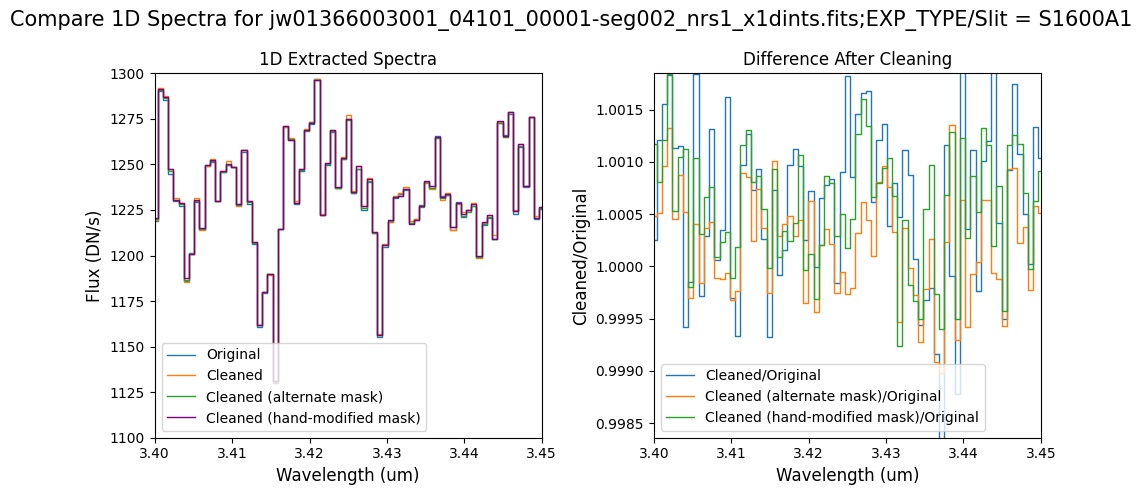

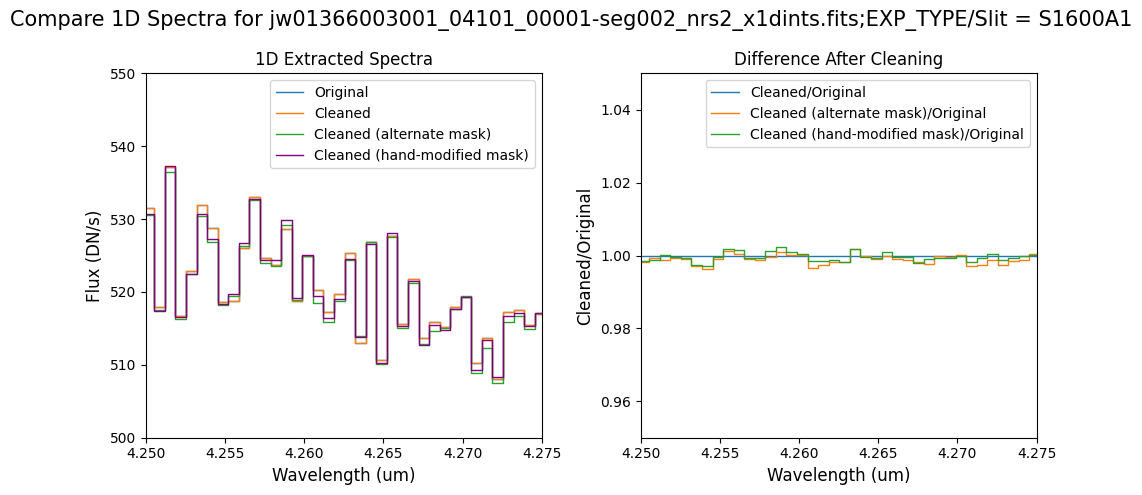

In [28]:
# Final Comparison
plot_spectra(
    [
        x1d_nsclean_skipped[0],
        x1d_nsclean_default[0],
        x1d_nsclean_alternate[0],
        x1d_nsclean_modified[0],
    ],
    ext_num=100,
    wavelength_range=wavelength_range,
    flux_range=flux_range,
)
plot_spectra(
    [
        x1d_nsclean_skipped[1],
        x1d_nsclean_default[1],
        x1d_nsclean_alternate[1],
        x1d_nsclean_modified[1],
    ],
    ext_num=100,
    wavelength_range=wavelength_range,
    flux_range=flux_range,
)

<div class="alert alert-block alert-info">
<b>Final Note:</b> Both the alternate (clip-based) and hand-modified masks produced similar results. However, the hand-modified mask appears to introduce less high-frequency noise.
</div>

## About the Notebook <a name="about"></a>

**Authors:** Melanie Clarke, Kayli Glidic; NIRSpec Instrument Team

**Updated On**: Feburary 29, 2024.

<hr style="border:0.5px solid black">

[Top of Page](#top)
